Here we want to produce
- a node-ranking based on graphlet occurrences with particular pmetric values (e.g. high degree), and
- a local neighbour hood analysis of specific nodes

In [1]:
"""Loading the raw human cancer pmetric data"""
from pathlib import Path

base = Path("/home/timgarrels/Projects/masterthesis/MA_analytics/notebooks/Dataset Refinement")
original = "unshifted_human_cancer_cutoff_0.935.edgelist"
shifted = "human_cancer_cutoff_0.935.edgelist"

In [2]:
dataset_used_for_pmetric_collection = Path("/home/timgarrels/Projects/masterthesis/MA_analytics/dataset/publication_human_cancer.edgelist")
out = Path("/home/timgarrels/Projects/masterthesis/MA_analytics/out/publication_human_cancer")

In [3]:
import networkx as nx


original_g = nx.read_edgelist(base / original, data=False) 
shifted_g = nx.read_edgelist(base / shifted, data=False)   
used_g = nx.read_edgelist(dataset_used_for_pmetric_collection, data=False)

In [4]:
# Test validity of mapping by asserting all subgraphs |n| < 10 to be isomorphic after mapping
from tqdm import tqdm


def test_isomorphism(g1, g2, node_mapping=None):
    if not node_mapping:
        node_mapping = {n: n for n in g1.nodes}

    for i, n in tqdm(enumerate(g1.nodes), total=len(g1.nodes)):
        node_set = [n] + list(g1.neighbors(n))


        mapped_node_set = [node_mapping[node] for node in node_set]

        mapped_node = node_mapping[n]

        o_sub = nx.induced_subgraph(g1, [n] + list(g1.neighbors(n)))
        o_sub = nx.induced_subgraph(g1, node_set)
        g_sub = nx.induced_subgraph(g2, [mapped_node] + list(g2.neighbors(mapped_node)))
        g_sub = nx.induced_subgraph(g2, mapped_node_set)

        if len(o_sub.nodes) > 10:
            continue

        if not nx.is_isomorphic(o_sub, g_sub):
            print(n, i)
            print("Bad: Subparts of the graphs are not isomorphic! Error in node mapping!")
            break

In [5]:
test_isomorphism(shifted_g, used_g)

100%|███████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 1845.10it/s]


In [6]:
node_mapping = dict(zip(original_g.nodes, used_g.nodes))
test_isomorphism(original_g, used_g, node_mapping)

100%|███████████████████████████████████████████████████████████████| 485/485 [00:00<00:00, 1587.30it/s]


In [7]:
from tqdm import tqdm
from functools import cache

from pmotif_lib.result_transformer import ResultTransformer
from pmotif_lib.p_metric.metric_consolidation import metrics

@cache
def get_result_df(k):
    r = ResultTransformer.load_result(
        dataset_used_for_pmetric_collection,
        out,
        graphlet_size=k,

    )

    for metric_name, consolidation_metric_list in tqdm(metrics.items(), desc="Consolidating"):
        for consolidation_name, consolidation_method in consolidation_metric_list:
            r.consolidate_metric(
                metric_name, consolidation_name, consolidation_method
            )
    return r.positional_metric_df

# Load dfs for the first time to cache them
_df3 = get_result_df(3)
_df4 = get_result_df(4)

Loading graphlet metrics for pGraphModuleParticipation: 100%|█| 36340/36340 [00:00<00:00, 369272.72it/s]
Consolidating: 100%|██████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.68it/s]
Loading graphlet metrics for pGraphModuleParticipation: 100%|█| 893482/893482 [00:02<00:00, 330791.02it/
Consolidating: 100%|██████████████████████████████████████████████████████| 3/3 [00:47<00:00, 15.78s/it]


# Local Node Neighbourhood

In [8]:
given_node = list(original_g.nodes)[0]
graphlet_class_name = "3-clique"

In [9]:
print(given_node)

EGFR


In [10]:
from pmotif_lib.graphlet_representation import graphlet_name_to_class


node = node_mapping[given_node]

if graphlet_class_name == "3-clique":
    graphlet_class = graphlet_name_to_class("Triangle")
elif graphlet_class_name == "4-clique":
    graphlet_class = graphlet_name_to_class("Double Crossed Square")
else:
    graphlet_class = graphlet_name_to_class(graphlet_class_name) if graphlet_class_name else None

In [11]:
def get_relevant_occurrences(k, node, graphlet_class=None):
    """Returns all graphlet occurrences of a given size which contain a given node.
    If graphlet class is specified, only occurrences of that class are returned."""
    df = get_result_df(k)

    df["relevant"] = df["nodes"].apply(lambda x: node in x)
    if graphlet_class:
        df = df[df["graphlet_class"] == graphlet_class]
    return df[df["relevant"]]

get_relevant_occurrences(3, node, graphlet_class=graphlet_class).head()

,graphlet_class,nodes,pGraphModuleParticipation,pDegree,pAnchorNodeDistance,max normalized anchor hop distance,min normalized anchor hop distance,mean normalized anchor hop distance,graph module participation ratio,degree,relevant
110,011 101 110,"[1, 343, 111]",[1],85,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",0.893186,0.0,0.531209,0.0625,85,True
117,011 101 110,"[1, 343, 80]",[1],66,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...",1.046010,0.0,0.563134,0.0625,66,True
154,011 101 110,"[1, 313, 110]","[0, 1]",81,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.785425,0.0,0.466655,0.1250,81,True
169,011 101 110,"[1, 313, 40]",[1],69,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",1.073801,0.0,0.587913,0.0625,69,True
180,011 101 110,"[1, 279, 272]",[1],60,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.046010,0.0,0.578714,0.0625,60,True


5it [00:00, 42.35it/s]


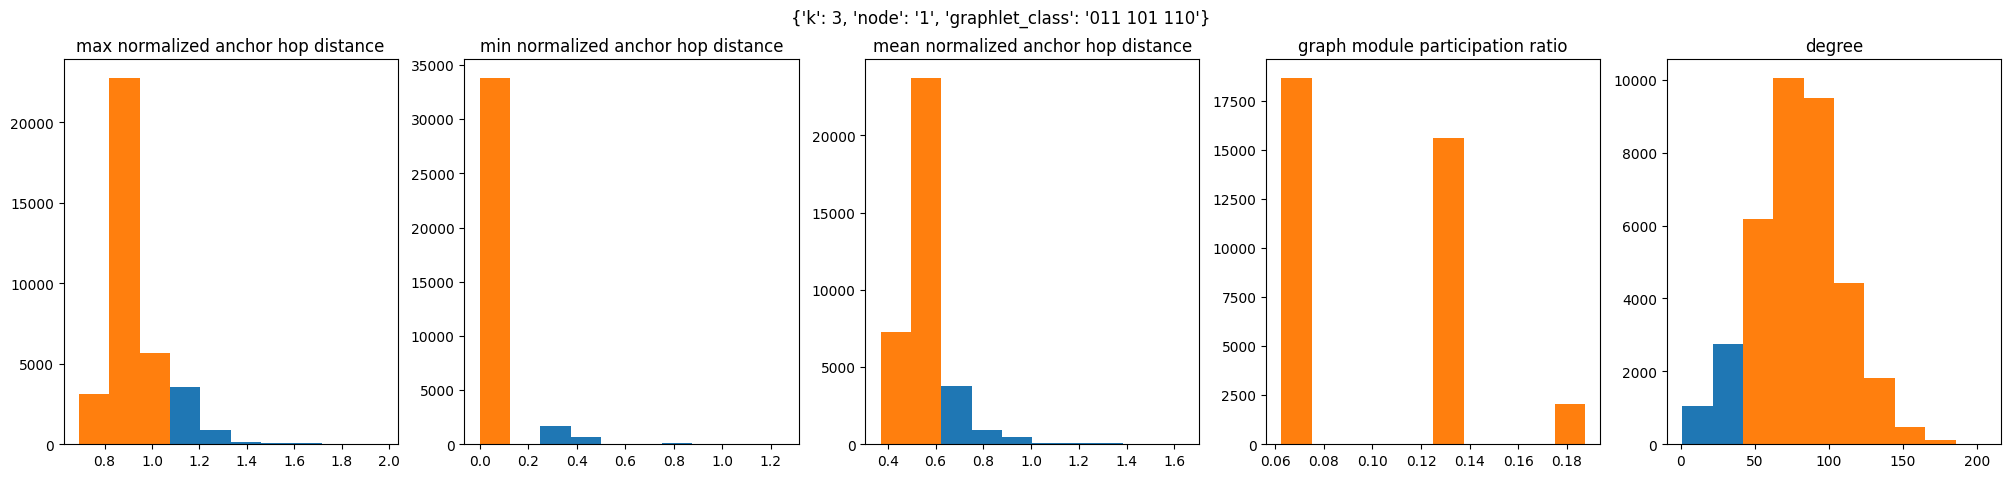

In [12]:
import matplotlib.pyplot as plt

def highlight_node_neighbourhood(k, node, graphlet_class=None):
    """Pots a histogram of pmetric values and highlights the values of graphlet occurrences
    hich are in the nieghbour hood of the given node"""
    metric_names = [name for consolidation in metrics.values() for name, _ in consolidation]
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 5))

    fig.suptitle(dict(k=k, node=node, graphlet_class=graphlet_class))
    
    df = get_result_df(k)
    relevant = get_relevant_occurrences(k, node, graphlet_class=graphlet_class)
    for i, m in tqdm(enumerate(metric_names)):
        ax = axes[i]
        ax.set_title(m)
        x, bins, patches = ax.hist(df[m])
        
        local_n_metric_values = relevant[m]
        
        _f, _ax = plt.subplots(1,1)

        relevant_x, _, _ = _ax.hist(
            local_n_metric_values,
            bins=bins,
        )
        plt.close()
        del _f
        del _ax
        
        """      
        bin_borders = zip([b for b in bins[:-1]], [b for b in bins[1:]])
        bin_middles = [bin_start + (bin_end - bin_start) / 2 for bin_start, bin_end in bin_borders]
        
        for middle, x in zip(bin_middles, relevant_x):
            if x > 0:
                ax.vlines(middle, ax.get_ylim()[0], ax.get_ylim()[1], color="tab:orange")
        """
        for p, x in zip(patches, relevant_x):
            if x > 0:
                p.set_facecolor("tab:orange")
    
    return fig
    
    
highlight_node_neighbourhood(3, node, graphlet_class)
pass


# Node Ranking

In [13]:
from collections import Counter
import pandas as pd
import statistics

pd.set_option('display.max_rows', 1000)

def particular_occurrences(k, graphlet_class, pmetric):
    """Returns rows where occurrences are above the 9th percentile of pmetric values"""
    df = get_result_df(k)
    df = df[df["graphlet_class"] == graphlet_class]
    values = df[pmetric]
        
    percentile_cuts = statistics.quantiles(values, n=100, method="exclusive")
    p95th = round(percentile_cuts[-5], 2)
    
    df = df[df[pmetric] > p95th]
    return df
    

def node_ranking_by_frequency(df):
    nodes = df["nodes"]
    all_nodes = [e for n in nodes for e in n]
    return Counter(all_nodes)


k = 4
graphlet_class_name = "4-Dash"

def get_node_ranking(k, gc, pmetric):
    gc = graphlet_name_to_class(gc)

    all_occurrences = get_result_df(k)
    all_occurrences = all_occurrences[all_occurrences["graphlet_class"] == gc]
    nodes_ranked_by_all_ocurrences = dict(node_ranking_by_frequency(all_occurrences))


    part = particular_occurrences(
        k,
        gc,
        pmetric,
    )
    total_occurrences = part.shape[0]
    counter = node_ranking_by_frequency(part)

    df = pd.DataFrame(columns=["node", "frequency"])
    df["node"] = counter.keys()
    df["frequency"] = counter.values()
    df["relative frequency"] = df["frequency"] / total_occurrences 

    # df["global frequency"] = df["node"].apply(lambda x: nodes_ranked_by_all_ocurrences[x])
    # df["global relative frequency"] = df["global frequency"] / sum(nodes_ranked_by_all_ocurrences.values())

    degrees = dict(used_g.degree)
    df["node degree"] = df["node"].apply(lambda x: degrees[x])

    # hub_degree_cut = statistics.mean(degrees.values()) + statistics.stdev(degrees.values())
    # df["is hub node"] = df["node degree"].apply(lambda x: x > hub_degree_cut)

    df["node name"] = df["node"].apply({v: k for k, v in node_mapping.items()}.get)
    df = df.sort_values("relative frequency", ascending=False)
    return df

df = get_node_ranking(k, graphlet_class_name, "graph module participation ratio")
df.head()

,node,frequency,relative frequency,node degree,node name
3,39,573,0.224178,74,TP53
15,77,565,0.221049,70,CTNNB1
27,95,503,0.196792,16,PTEN
9,132,435,0.170188,36,BRCA1
22,282,353,0.138106,26,SMARCA4


Text(0.5, 1.0, 'All nodes')

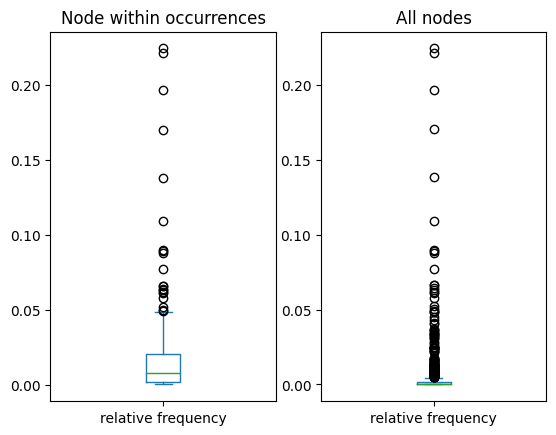

In [14]:
"""Prototype: Comapre Node Ranking with all nodes vs node ranking with only nodes which occurr"""
df = get_node_ranking(k, graphlet_class_name, "graph module participation ratio")
# Add all the missing nodes
missing_nodes = set(node_mapping.keys()) - set(df["node"])
degree = used_g.degree()
new_rows = [{
    "node": node_mapping[mn],
    "frequency": 0,
    "relative frequency": 0,
    "node degree": degree[node_mapping[mn]],
    "node name": mn
} for mn in missing_nodes]

fig, (ax1, ax2) = plt.subplots(1,2)

df["relative frequency"].plot.box(ax=ax1)

pd.concat([df, pd.DataFrame(new_rows)])["relative frequency"].plot.box(ax=ax2)
ax1.set_title("Node within occurrences")
ax2.set_title("All nodes")

4-Dash (210, 5)
Fork (202, 5)
Spoon (145, 5)
Square (248, 5)
Crossed Square (273, 5)
Double Crossed Square (142, 5)


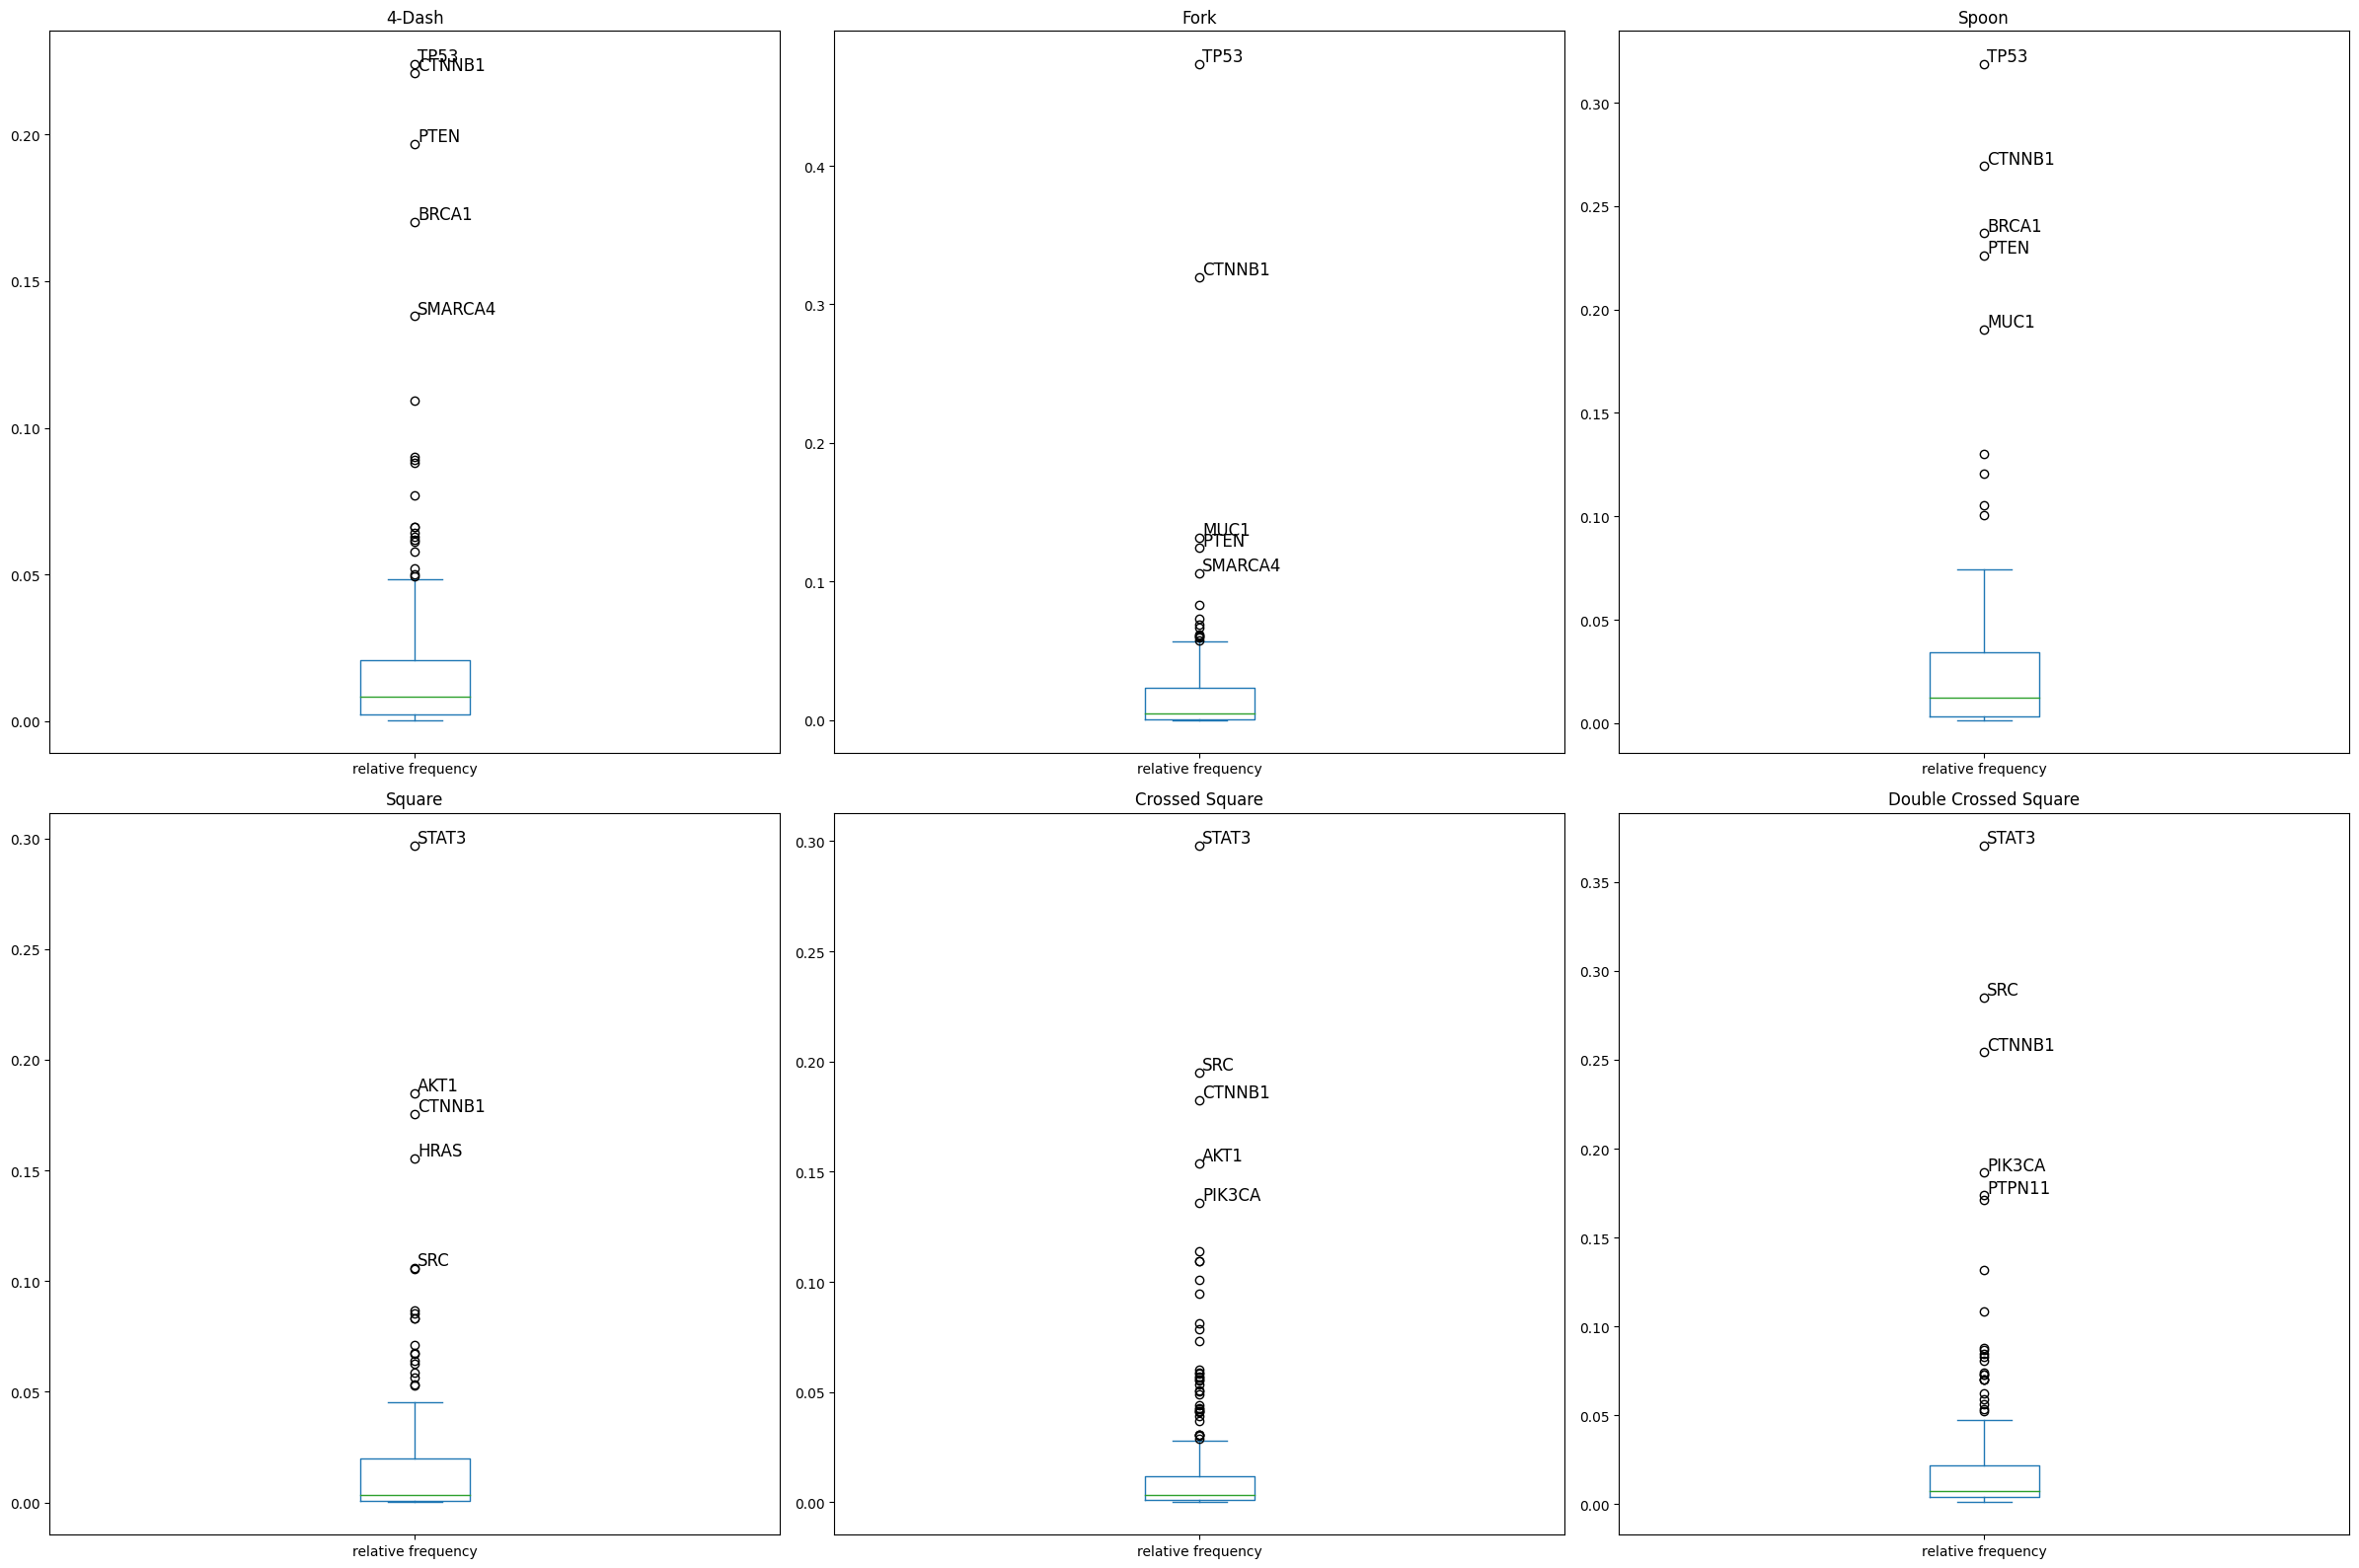

In [15]:
from pmotif_lib.graphlet_representation import graphlet_class_to_name, graphlet_classes_from_size


classes = graphlet_classes_from_size(4)
dimension = 8

fig, axes = plt.subplots(
    2,
    3,
    figsize=(dimension * 3, dimension * 2),
)
axes = axes.flatten()

for i, gc in enumerate(classes):
    k = 4
    gc_name = graphlet_class_to_name(gc)
    df = get_node_ranking(k, gc_name, "graph module participation ratio")
    print(gc_name, df.shape)

    if df.shape[0] == 0:
        continue

    ax = axes[i]
    df["relative frequency"].plot.box(ax=ax)
    ax.set_title(gc_name)
    
    # Annotate top outliers
    top_x = 5
    outliers = df.iloc[:top_x]
    for i, r in outliers.iterrows():
        ax.annotate(
            r["node name"],
            xy=(1, r["relative frequency"]),
            xytext=(2,2),
            textcoords='offset points',
            fontsize=12,
        )
fig.tight_layout()

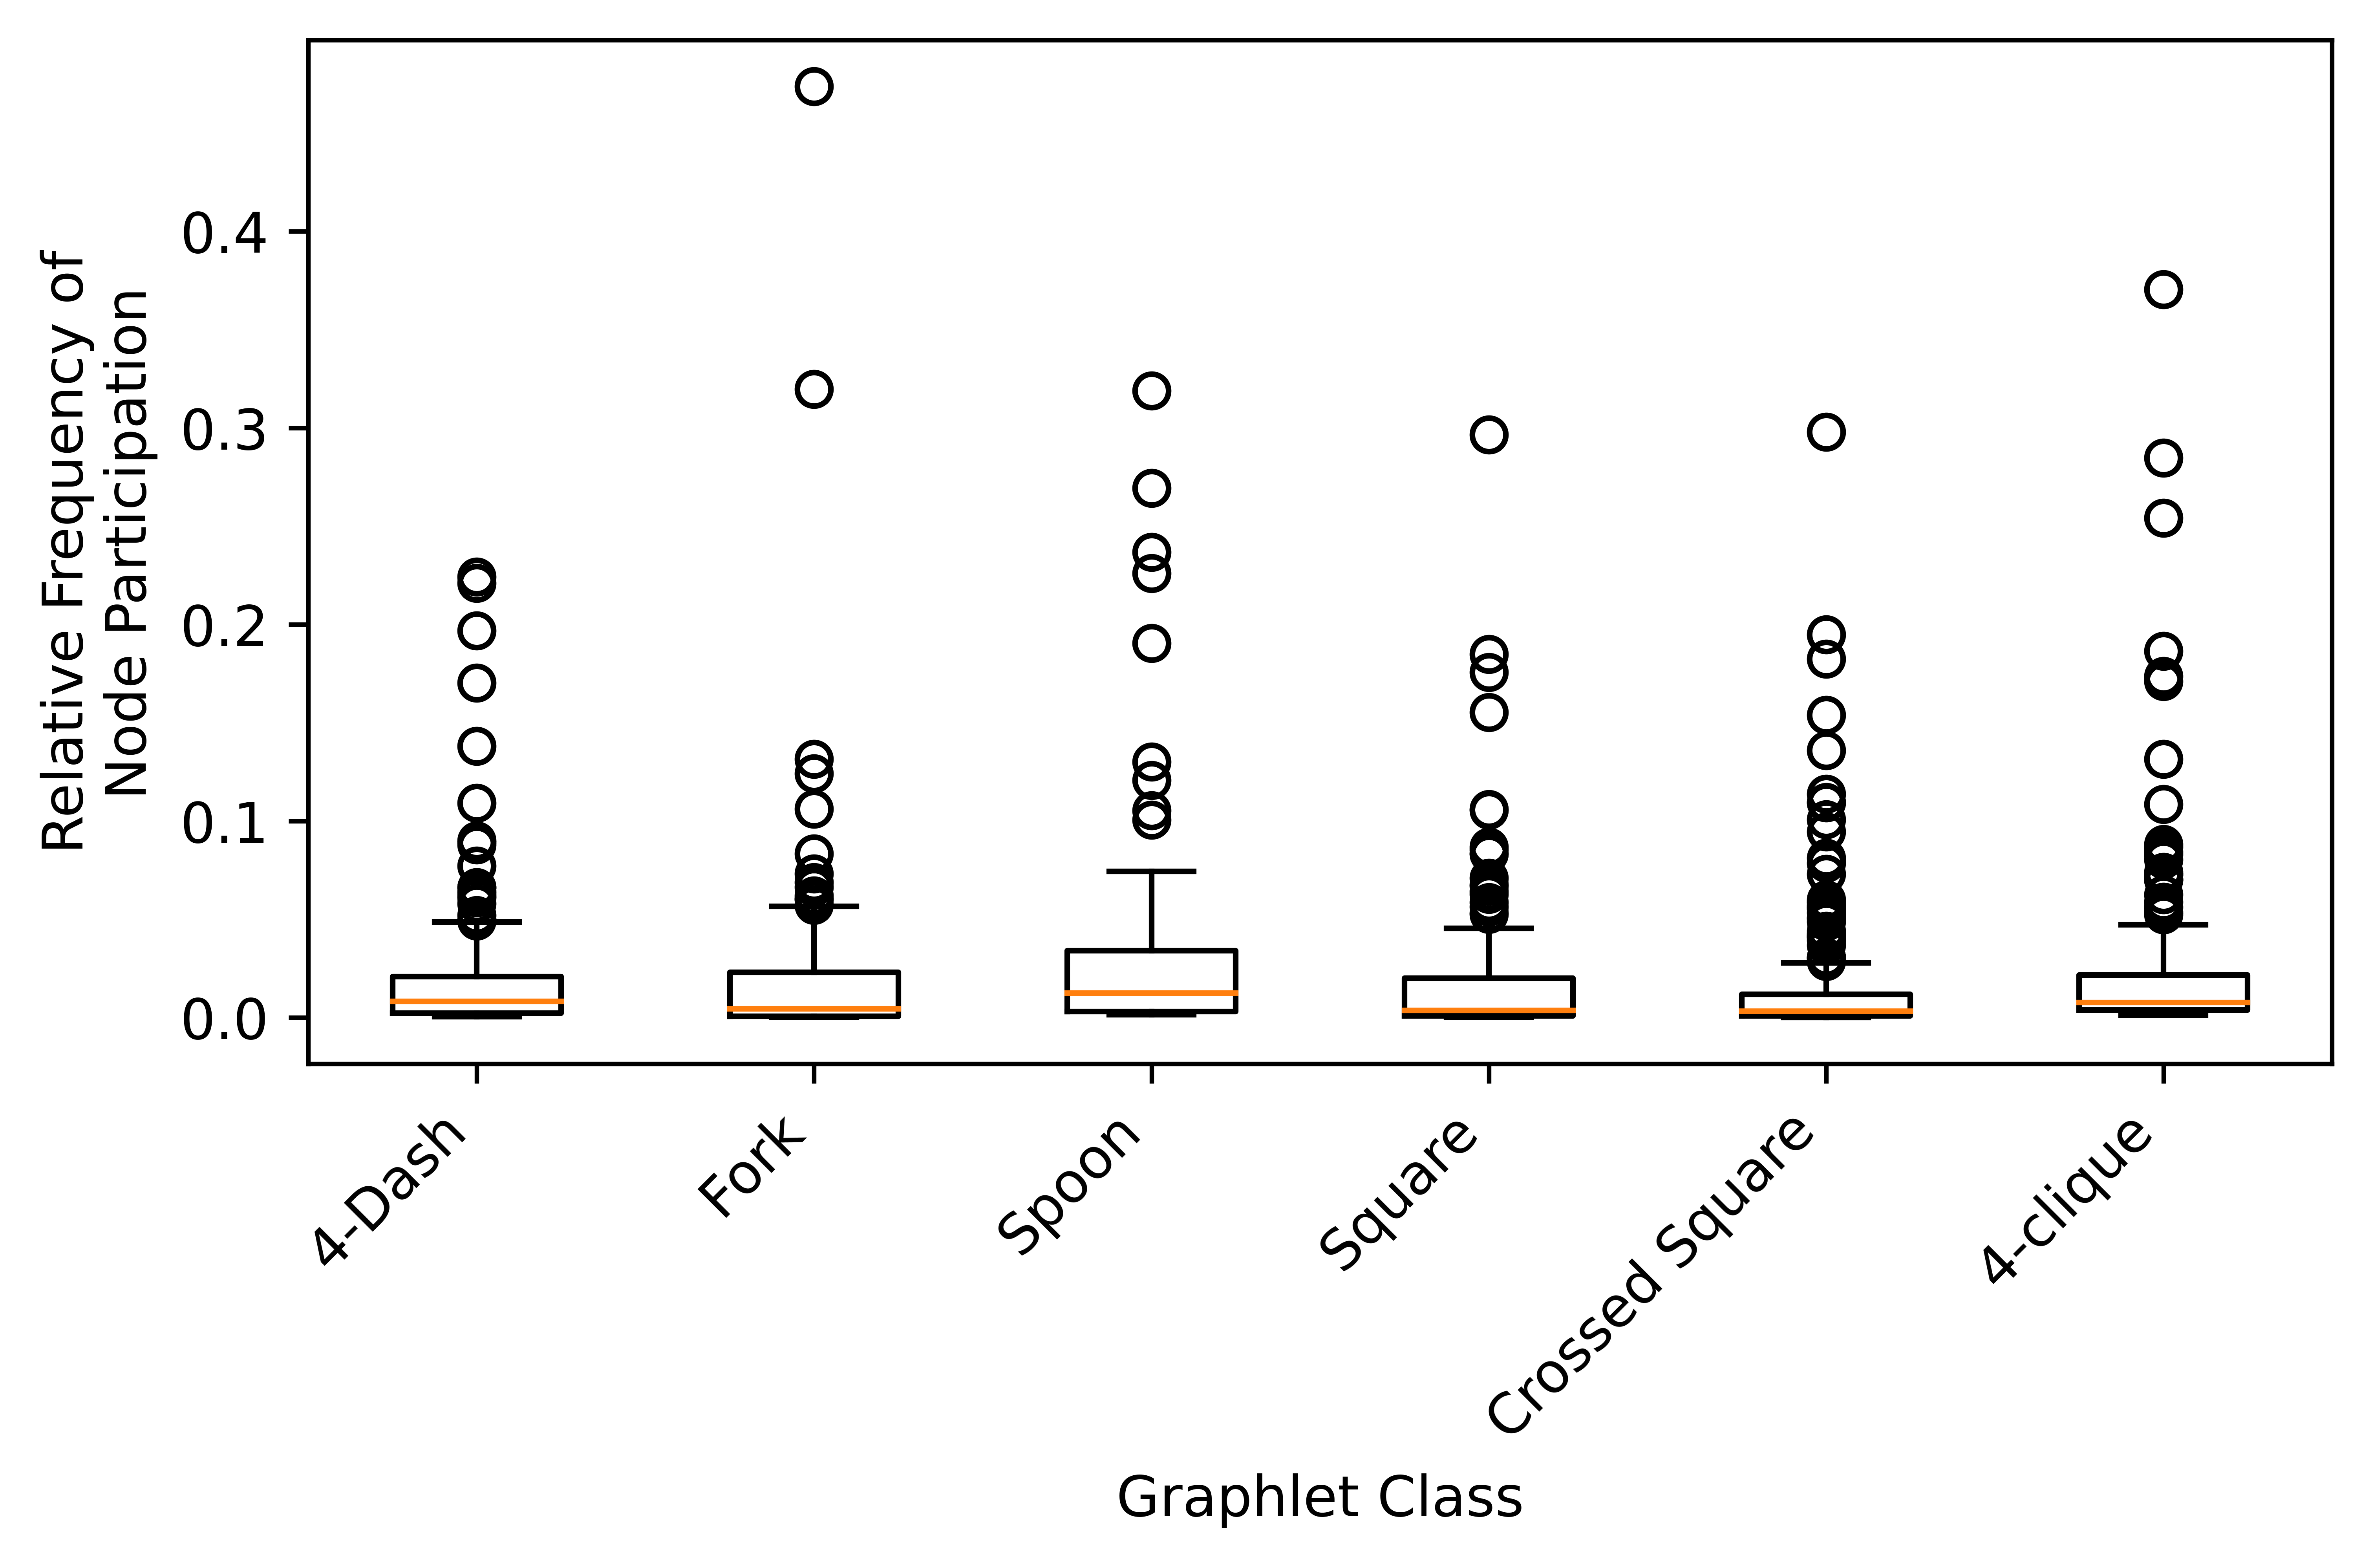

In [16]:
from pmotif_lib.graphlet_representation import graphlet_class_to_name, graphlet_classes_from_size

import matplotlib

classes = graphlet_classes_from_size(4)

fig, ax = plt.subplots(figsize=(6, 4), dpi=1024)

k = 4

data = {}
for gc in classes:
    gc_name = graphlet_class_to_name(gc)
    df = get_node_ranking(k, gc_name, "graph module participation ratio")
    
    if df.shape[0] == 0:
        continue
    data[gc_name] = df


plot_values = [d["relative frequency"] for d in data.values()]
plot_labels = [
    l if "Double" not in l else "4-clique"
    for l in data.keys()
]
ax.boxplot(plot_values, labels=plot_labels)

top_x = 10
tops = {}
node_ranking = {}
for i, (gc_name, df) in enumerate(data.items()):
    outliers = df.iloc[:top_x]
    tops[gc_name] = list(outliers["node name"])
    node_ranking[gc_name] = df["node name"]
    continue
    for j, r in outliers.iterrows():
        ax.annotate(
            r["node name"],
            xy=(i + 1 , r["relative frequency"]),
            xytext=(3,3),
            textcoords='offset points',
            fontsize=8,
        )


ax.set_ylabel("Relative Frequency of\n Node Participation")
ax.set_xlabel("Graphlet Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
fig.tight_layout()

In [17]:
from collections import Counter
Counter([node for v in tops.values() for node in v])

Counter({'TP53': 6,
         'CTNNB1': 6,
         'AKT1': 6,
         'SRC': 4,
         'PTEN': 3,
         'BRCA1': 3,
         'SMARCA4': 3,
         'MUC1': 3,
         'STAT3': 3,
         'JUN': 3,
         'PIK3CA': 3,
         'CASP3': 2,
         'AURKA': 2,
         'STK11': 2,
         'EP300': 2,
         'EGFR': 2,
         'PTPN11': 2,
         'NF1': 1,
         'VHL': 1,
         'HRAS': 1,
         'KRAS': 1,
         'EGF': 1})

Plot second histogram into locl neighbourhood with a scaling factor


Connecting Occurrence - High Module Particiaption Ratio (95th)
Graphlet Occurrences - Squares (all 3), Triangle, Spoon, 4-Dash, 3-Dash
Add all nodes into df, if they do not occurr at all, socre=0


In [18]:
pub_res = df[["node name", "frequency", "relative frequency"]]
pub_res = pub_res.rename(columns={"node name": "Node", "frequency": "Frequency", "relative frequency": "Relative Frequency"})
pub_res = pub_res.set_index("Node")

def row_to_latex(i_n, r):
    return  f'{i_n} & {int(r["Frequency"])} & {round(r["Relative Frequency"], 4)}'


for i, (i_n, r) in enumerate(pub_res.iterrows()):
    print(row_to_latex(i_n, r), r"\\")

if False:
    df1, df2, df3 = (pub_res.iloc[:67], pub_res.iloc[67:67*2], pub_res.iloc[67*2:])
    df2_rows = list(df2.iterrows())
    df3_rows = list(df3.iterrows())

    s = ""
    for i, (i_n, r) in enumerate(df1.iterrows()):
        s += row_to_latex(i_n, r)

        i_n, r = df2_rows[i]
        s += " & " + row_to_latex(i_n, r)

        i_n, r = df3_rows[i]
        s += " & " + row_to_latex(i_n, r) + r"\\"
        print(s)
        s = ""

STAT3 & 290 & 0.3704 \\
SRC & 223 & 0.2848 \\
CTNNB1 & 199 & 0.2542 \\
PIK3CA & 146 & 0.1865 \\
PTPN11 & 136 & 0.1737 \\
EGFR & 134 & 0.1711 \\
AKT1 & 103 & 0.1315 \\
TP53 & 85 & 0.1086 \\
EGF & 69 & 0.0881 \\
JUN & 68 & 0.0868 \\
ESR1 & 66 & 0.0843 \\
RHOA & 65 & 0.083 \\
BRCA1 & 63 & 0.0805 \\
FYN & 58 & 0.0741 \\
STAT5B & 57 & 0.0728 \\
EP300 & 57 & 0.0728 \\
CREBBP & 55 & 0.0702 \\
ERBB2 & 55 & 0.0702 \\
VEGFA & 55 & 0.0702 \\
SMARCA4 & 49 & 0.0626 \\
RAC1 & 46 & 0.0587 \\
ATM & 44 & 0.0562 \\
PDGFRB & 42 & 0.0536 \\
CCND1 & 41 & 0.0524 \\
JAK2 & 37 & 0.0473 \\
IL6 & 33 & 0.0421 \\
MYC & 32 & 0.0409 \\
CDH1 & 30 & 0.0383 \\
FOS & 30 & 0.0383 \\
LCK & 26 & 0.0332 \\
AR & 21 & 0.0268 \\
CDKN1A & 21 & 0.0268 \\
LYN & 21 & 0.0268 \\
BRCA2 & 18 & 0.023 \\
IL1B & 17 & 0.0217 \\
MDM2 & 17 & 0.0217 \\
CDK2 & 17 & 0.0217 \\
MUC1 & 17 & 0.0217 \\
KDR & 17 & 0.0217 \\
TNF & 16 & 0.0204 \\
RAD51 & 16 & 0.0204 \\
MAP2K1 & 16 & 0.0204 \\
ABL1 & 15 & 0.0192 \\
MET & 15 & 0.0192 \\
CHEK2 & 14 & 0.

In [19]:
df.head(10)

,node,frequency,relative frequency,node degree,node name
20,31,290,0.370370,64,STAT3
10,145,223,0.284802,54,SRC
9,77,199,0.254151,70,CTNNB1
13,29,146,0.186462,46,PIK3CA
12,72,136,0.173691,53,PTPN11
0,1,134,0.171137,47,EGFR
47,157,103,0.131545,55,AKT1
55,39,85,0.108557,74,TP53
7,34,69,0.088123,27,EGF
41,94,68,0.086845,43,JUN


5it [00:00, 16.36it/s]


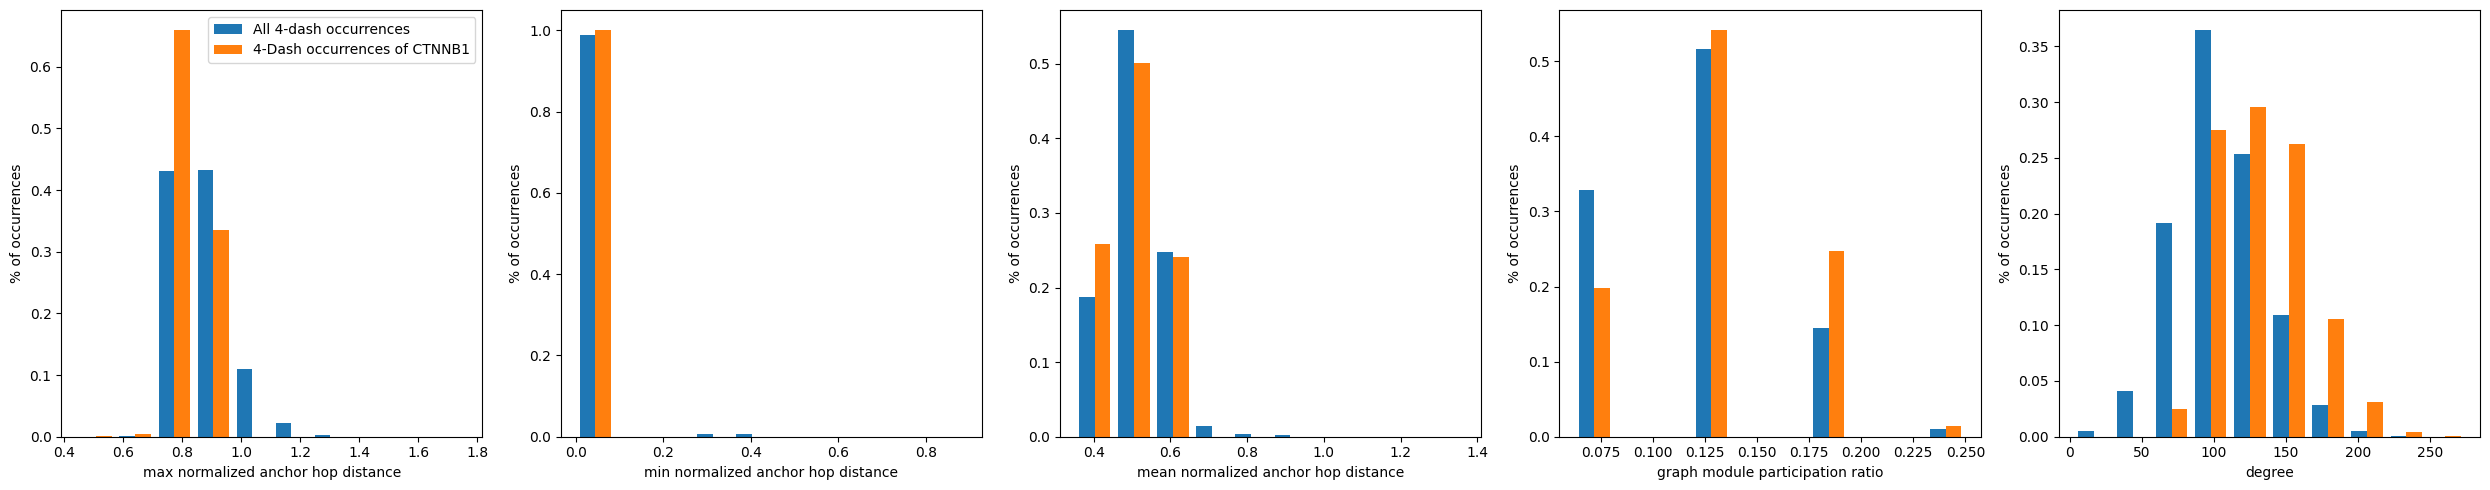

In [20]:
"""Pots a histogram of pmetric values and highlights the values of graphlet occurrences
hich are in the nieghbour hood of the given node"""
import numpy as np


def plot_local_neighbourhood(k, gc, node_name, relative=False):
    graphlet_class = graphlet_name_to_class(gc)
    node = node_mapping[node_name]
    

    metric_names = [name for consolidation in metrics.values() for name, _ in consolidation]
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 5))

    # fig.suptitle(dict(node_name=node_name, k=k, node=node, graphlet_class=graphlet_class))

    df = get_result_df(k)
    relevant = get_relevant_occurrences(k, node, graphlet_class=graphlet_class)
    for i, m in tqdm(enumerate(metric_names)):
        ax = axes[i]
        ax.set_xlabel(m)
        ax.set_ylabel("% of occurrences")
        local_n_metric_values = relevant[m]
        
        data = [
            df[m],
            list(local_n_metric_values),
        ]
        x, bins, patches = ax.hist(
            data,
            weights=[np.zeros_like(d) + 1. / len(d) for d in data],
            label=["All 4-dash occurrences", "4-Dash occurrences of CTNNB1"]
        )
    axes[0].legend()
    fig.tight_layout()
    return fig

k = 4
graphlet_class_name = "4-Dash"
node = "TP53"
fig = plot_local_neighbourhood(k, graphlet_class_name, node)
pass

5it [00:00, 15.94it/s]


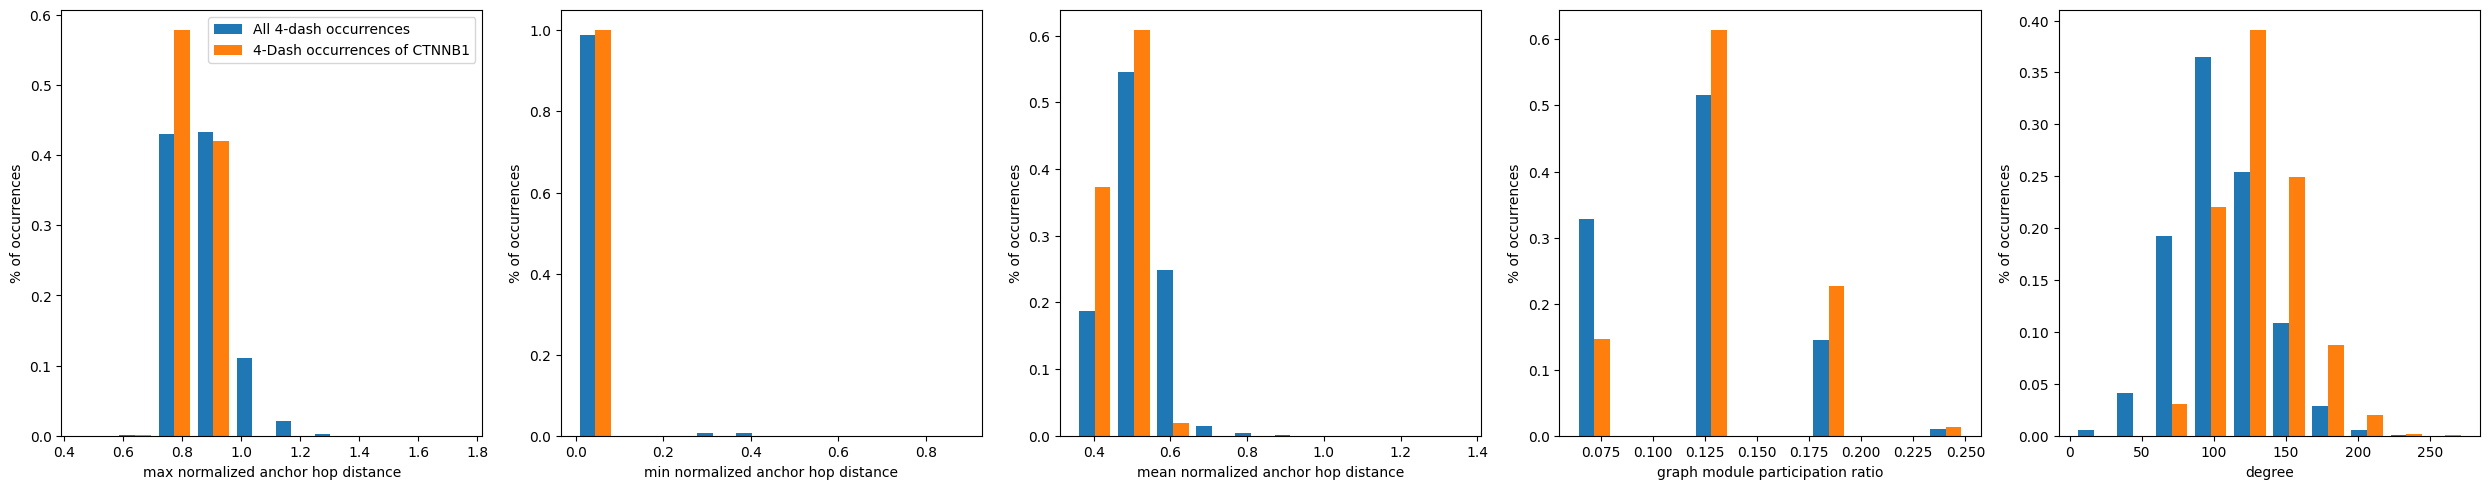

In [21]:
k = 4
graphlet_class_name = "4-Dash"
node = "CTNNB1"
fig = plot_local_neighbourhood(k, graphlet_class_name, node)
pass

In [22]:
fig.savefig("human_cancer_local_neigh.pdf")

5it [00:00, 16.17it/s]
5it [00:00, 18.02it/s]
5it [00:00, 17.52it/s]
5it [00:00, 19.71it/s]
5it [00:00, 18.36it/s]
5it [00:00, 17.37it/s]
5it [00:00, 18.62it/s]
5it [00:00, 20.36it/s]
5it [00:00, 19.12it/s]
5it [00:00, 18.55it/s]
5it [00:00, 19.29it/s]
5it [00:00, 19.08it/s]
5it [00:00, 19.70it/s]
5it [00:00, 19.81it/s]
5it [00:00, 17.50it/s]
5it [00:00, 19.49it/s]
5it [00:00, 20.20it/s]
5it [00:00, 18.63it/s]
5it [00:00, 17.53it/s]
5it [00:00, 19.92it/s]
/tmp/ipykernel_8188/258405119.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 5))
5it [00:00, 19.10it/s]
5it [00:00, 18.60it/s]


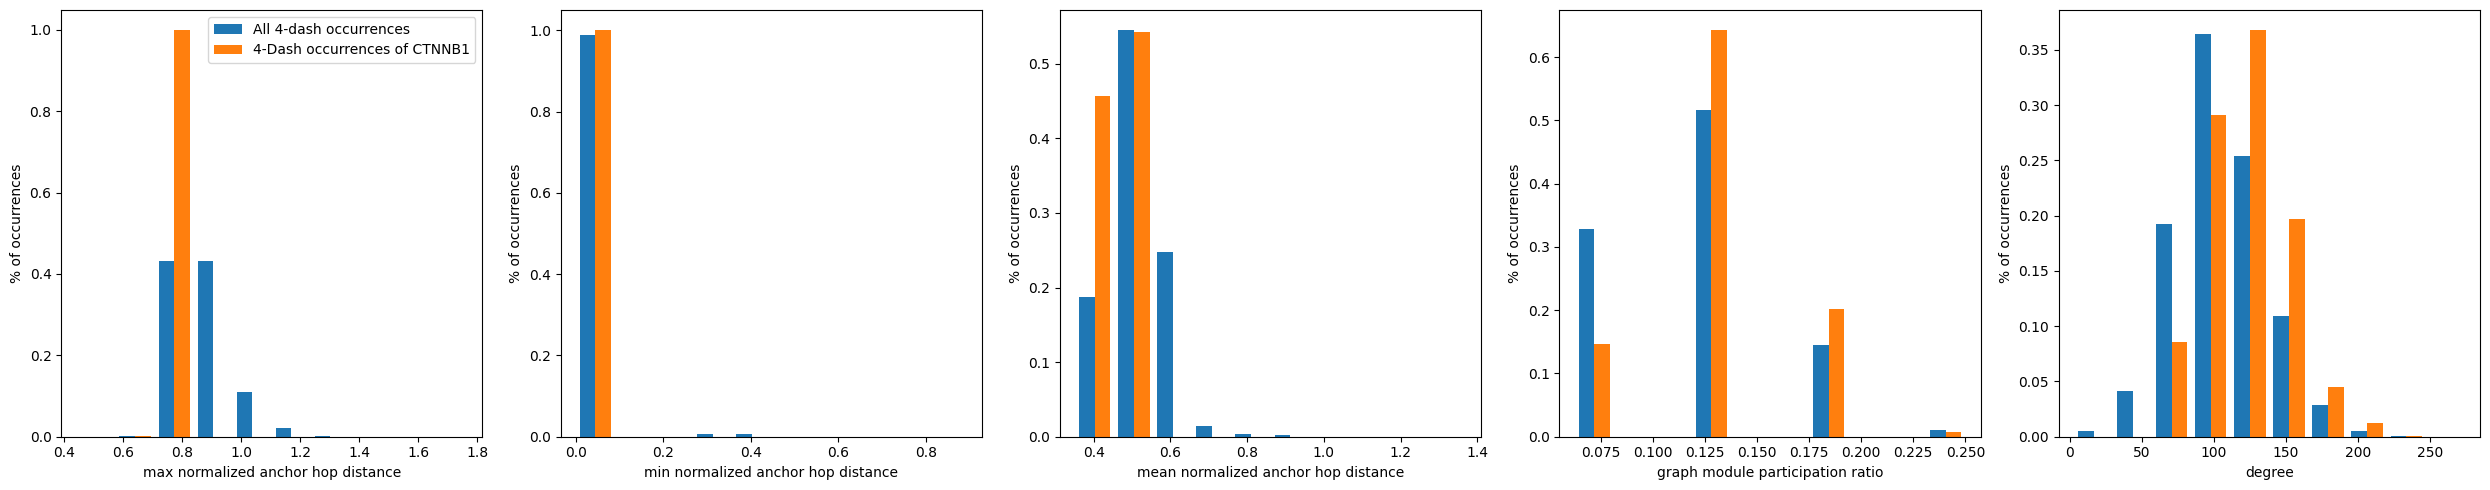

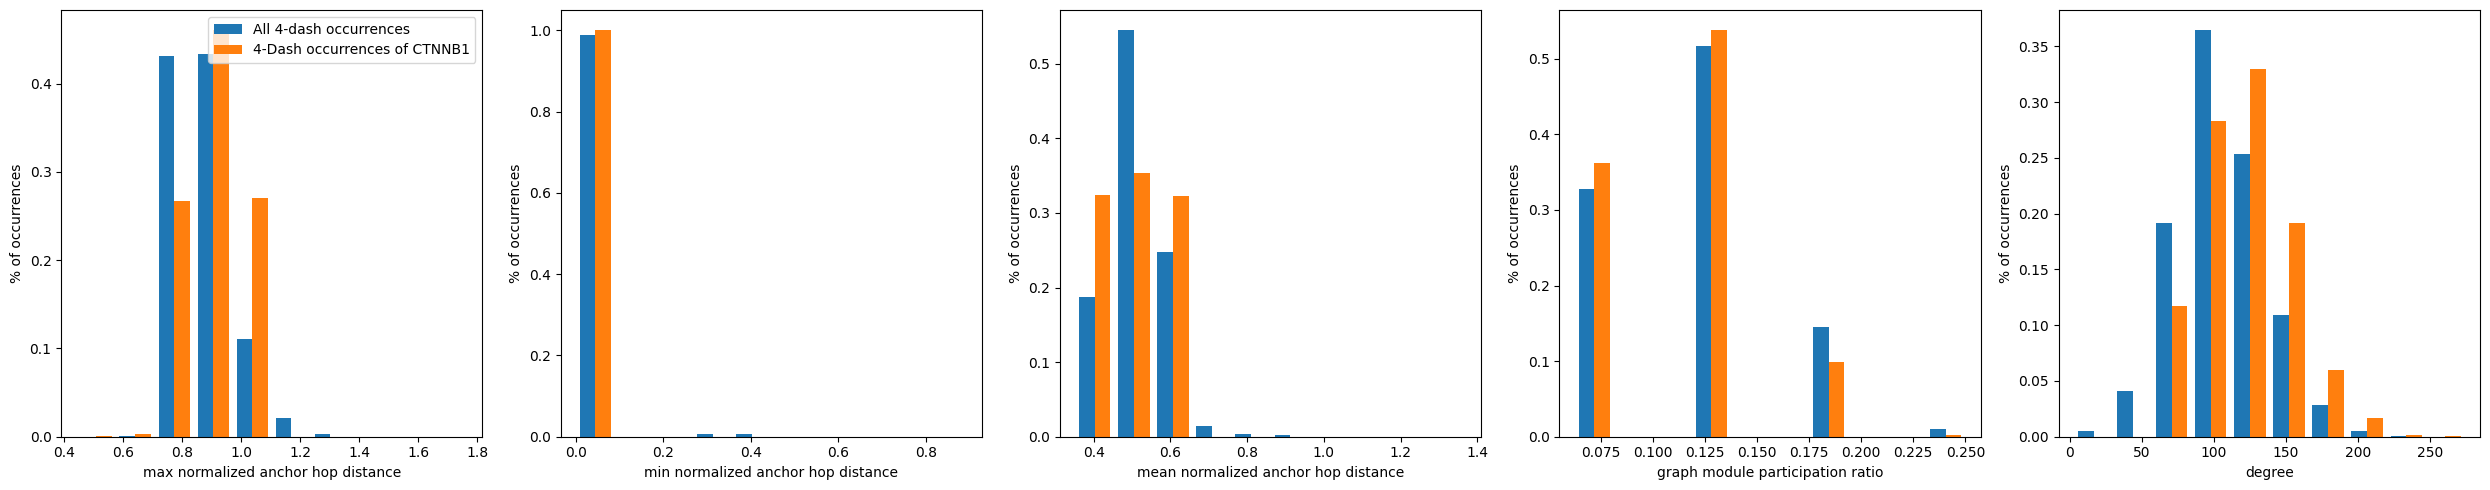

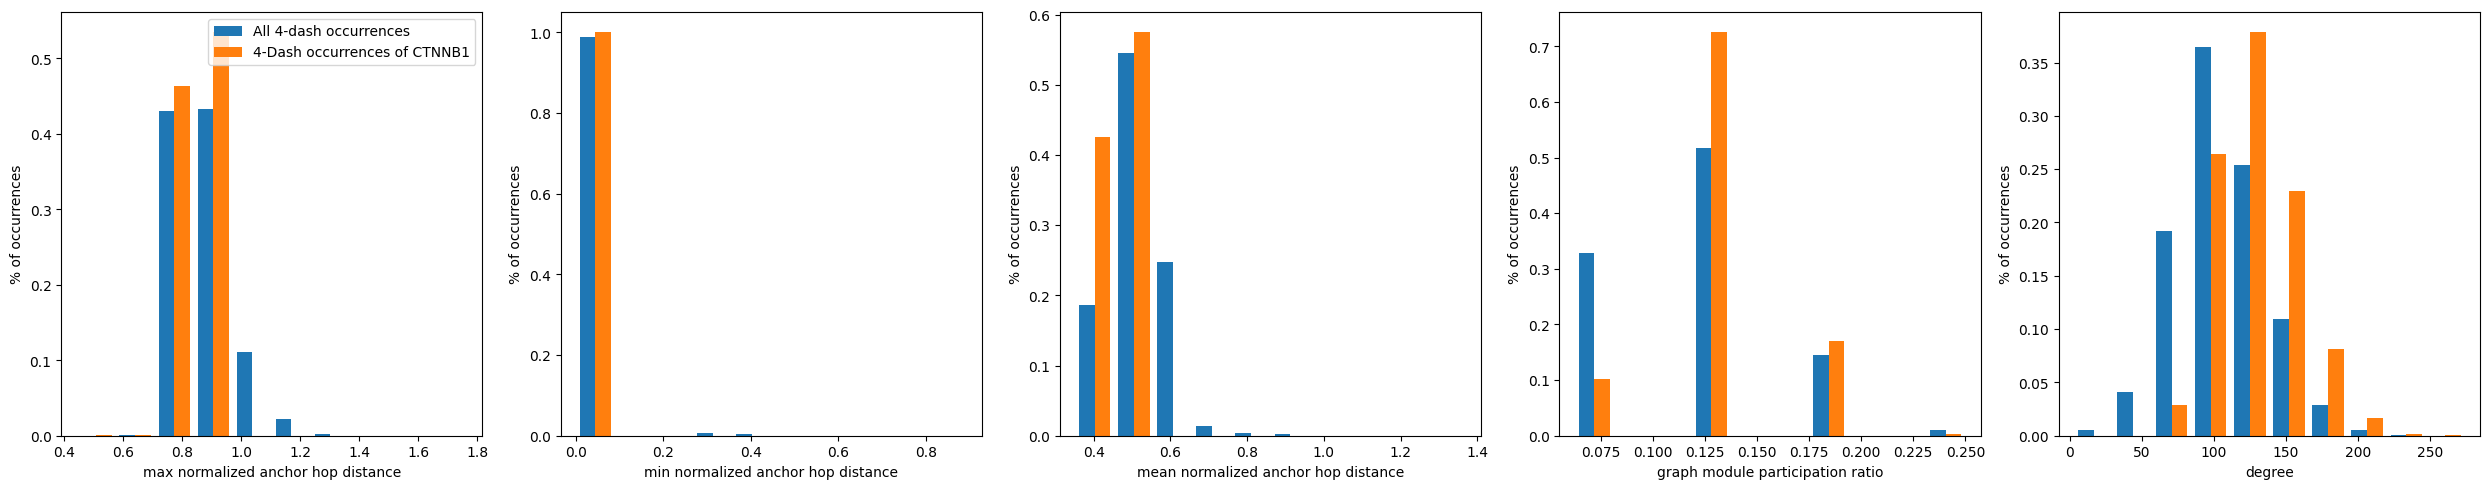

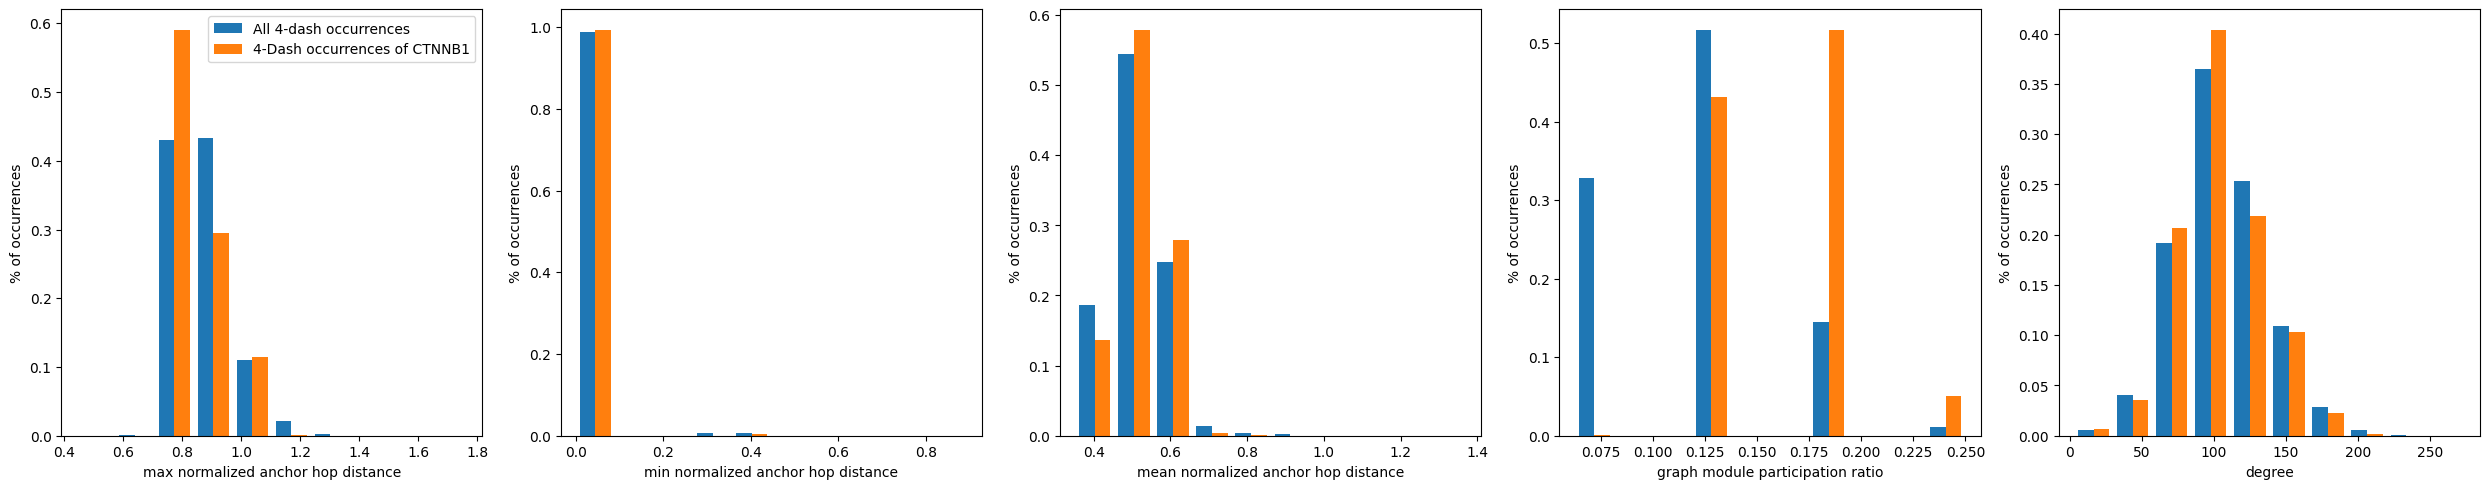

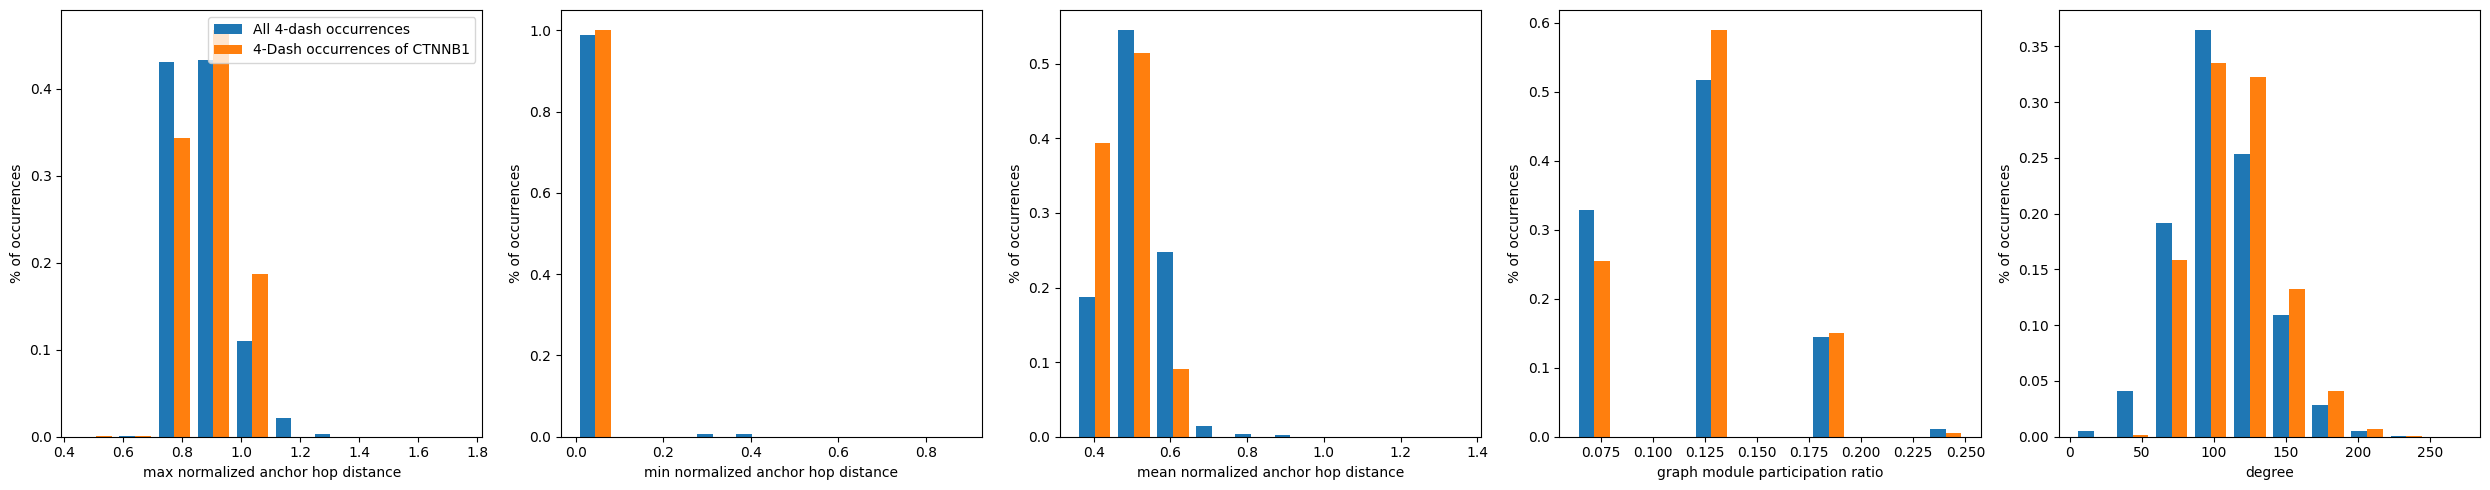

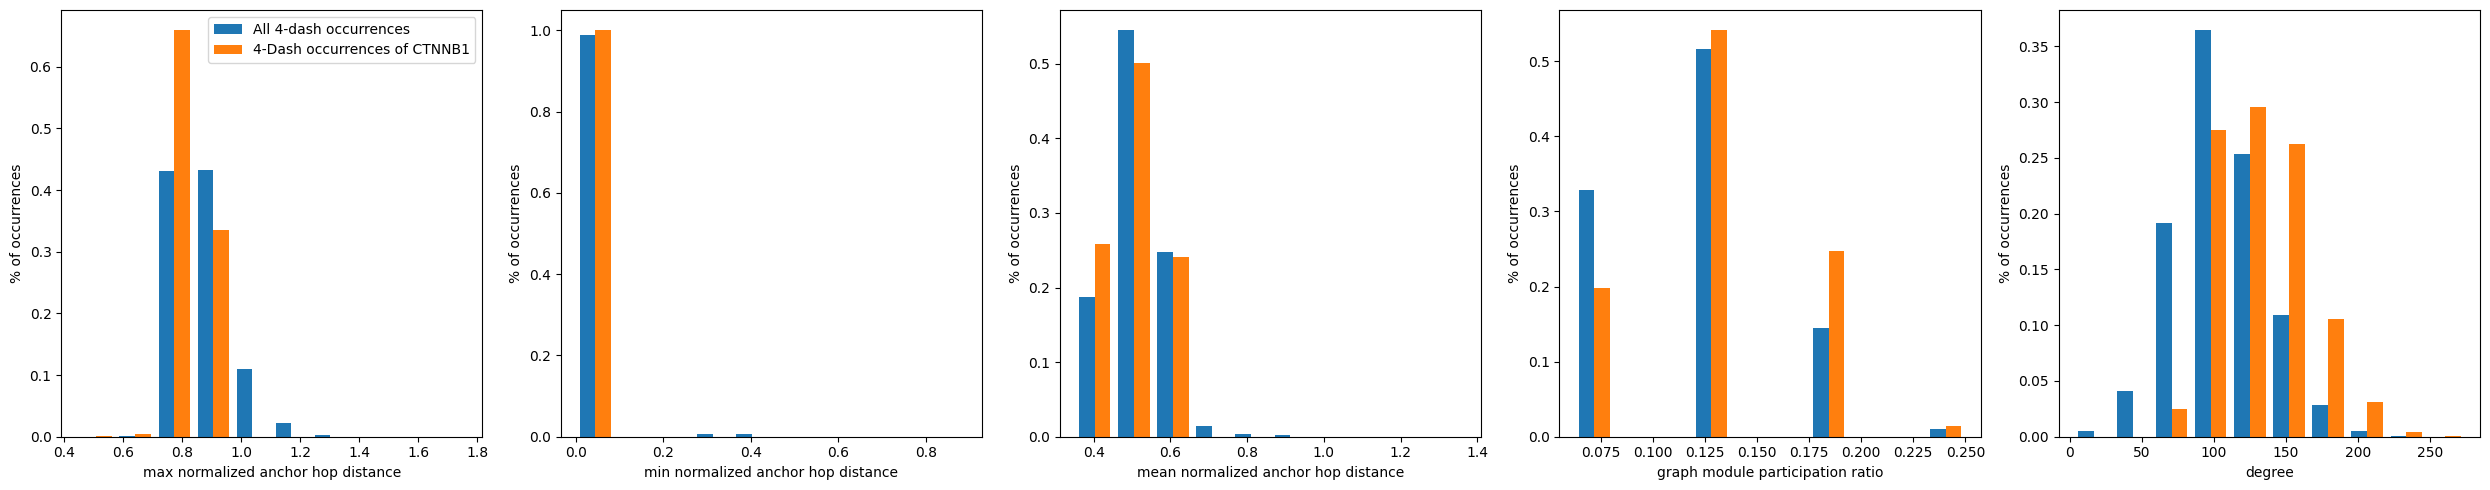

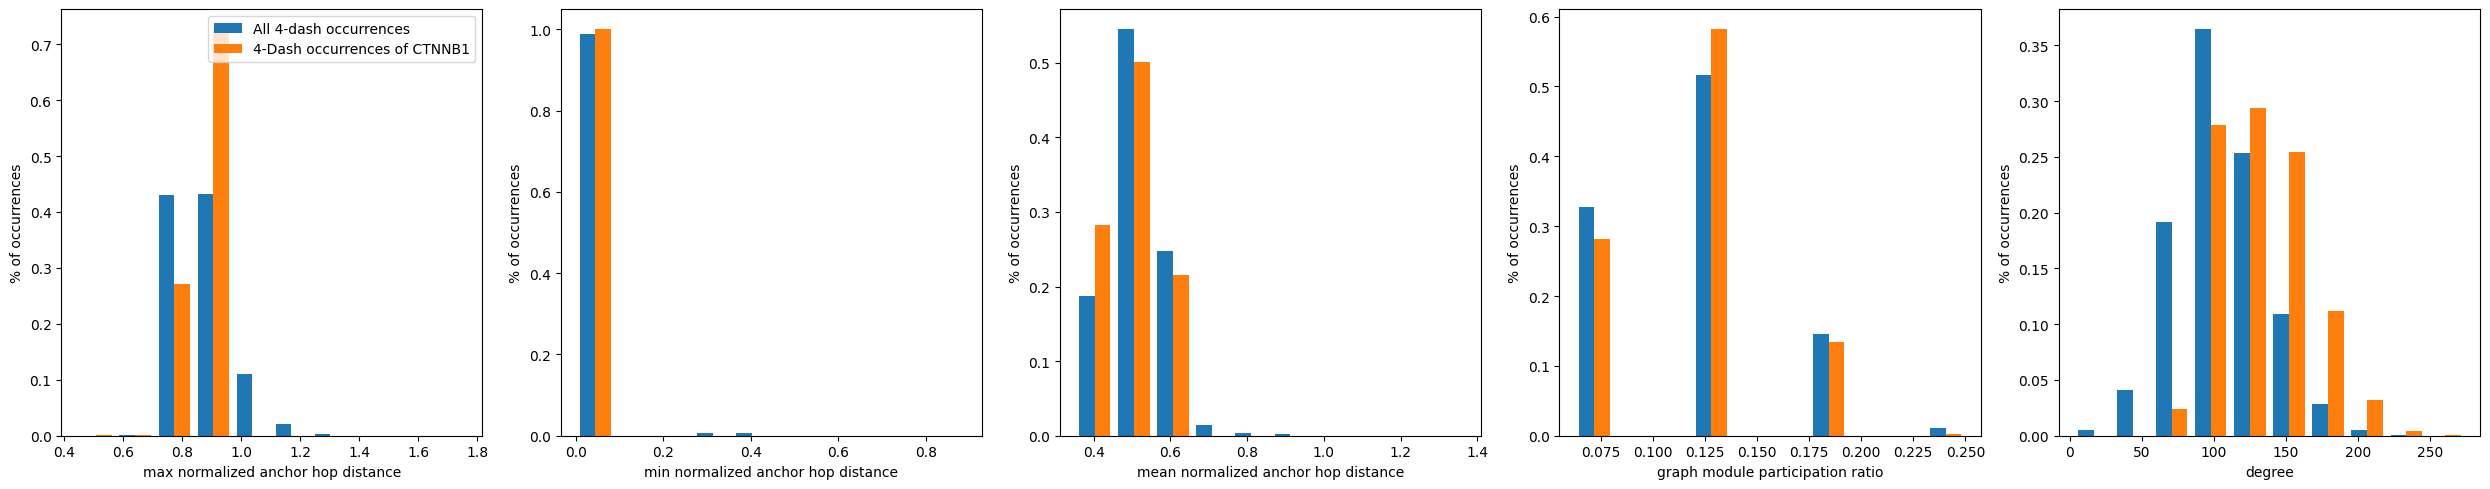

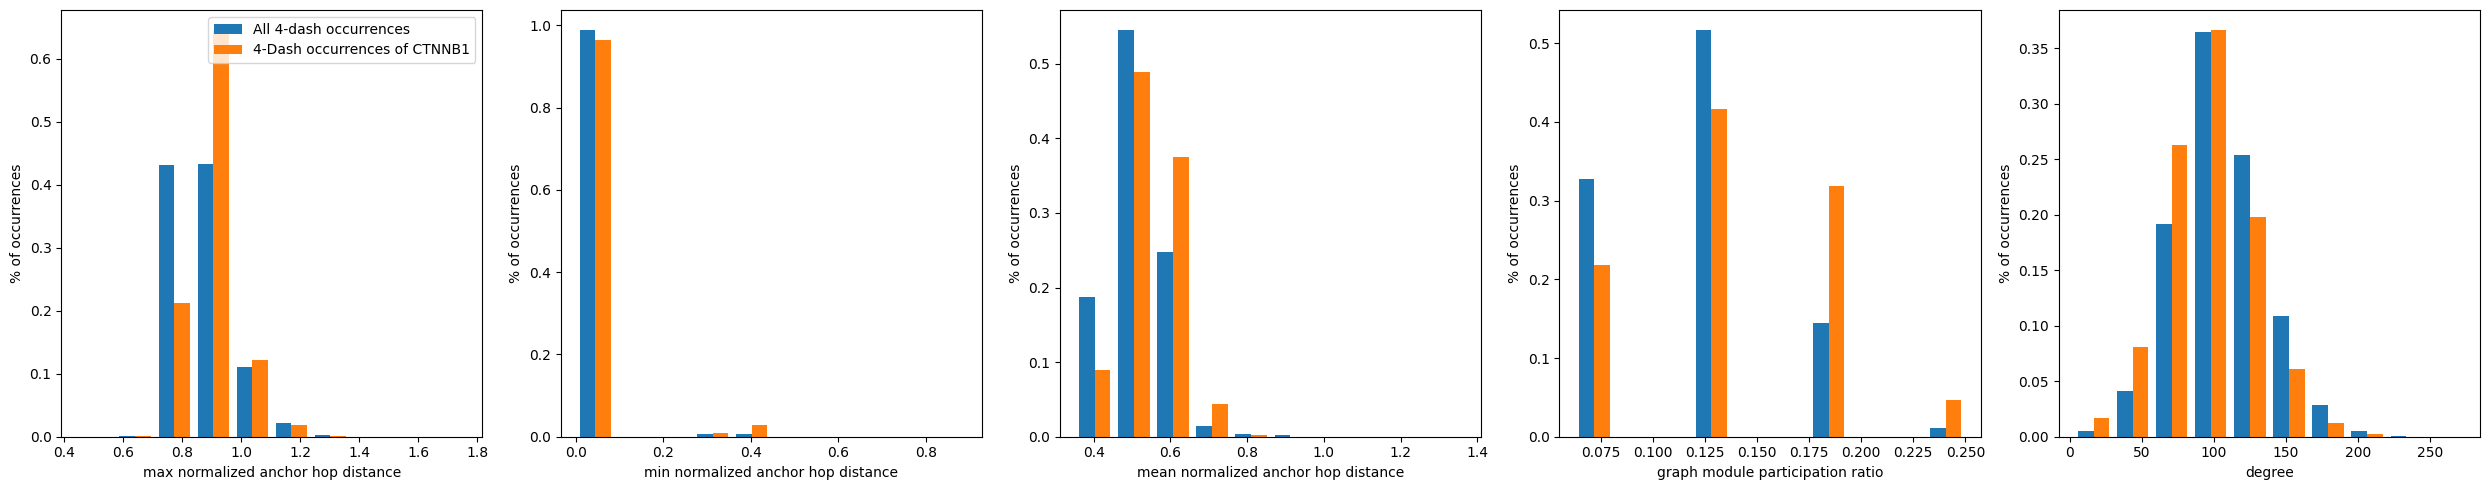

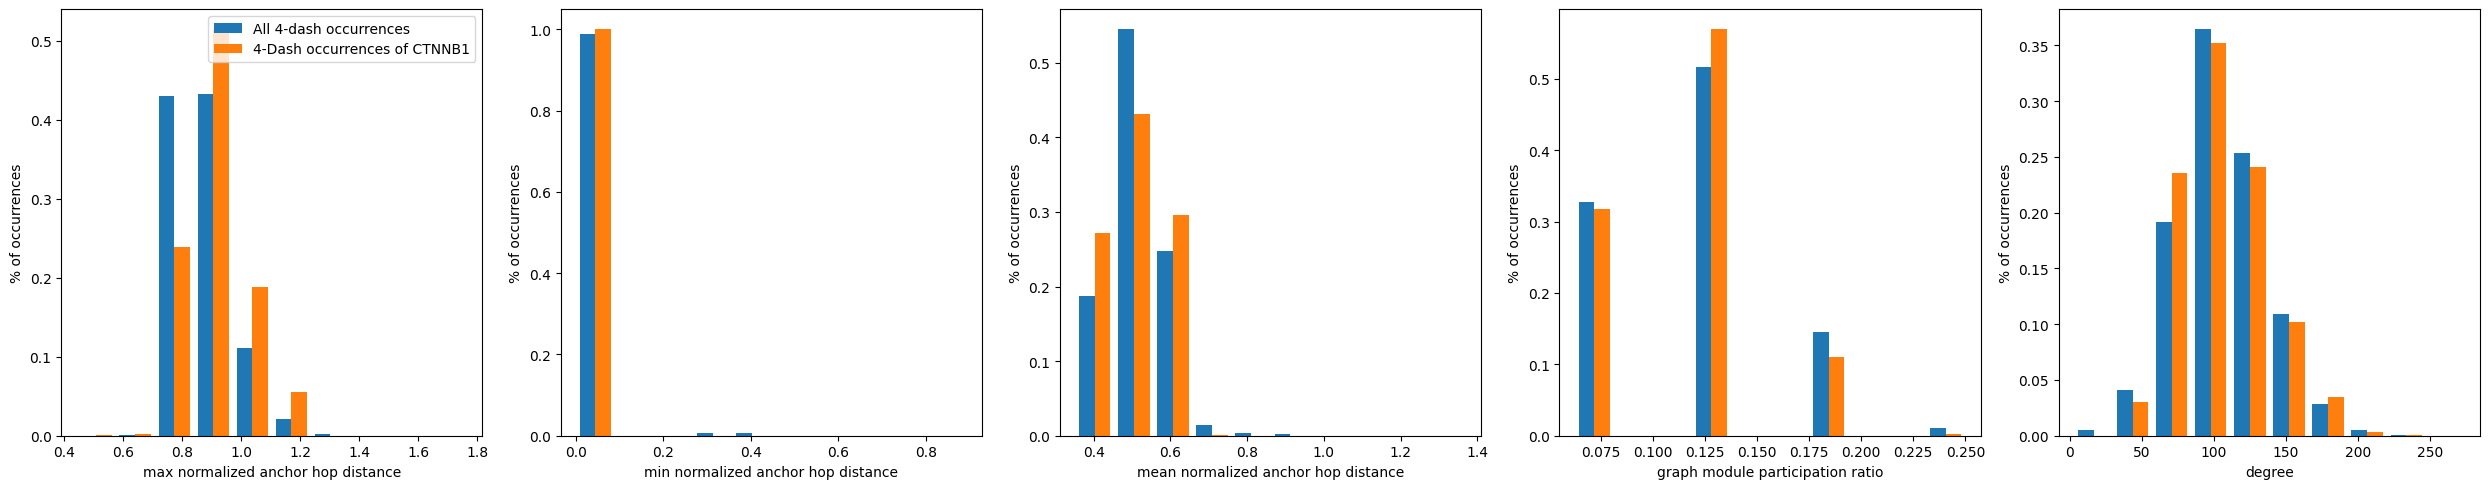

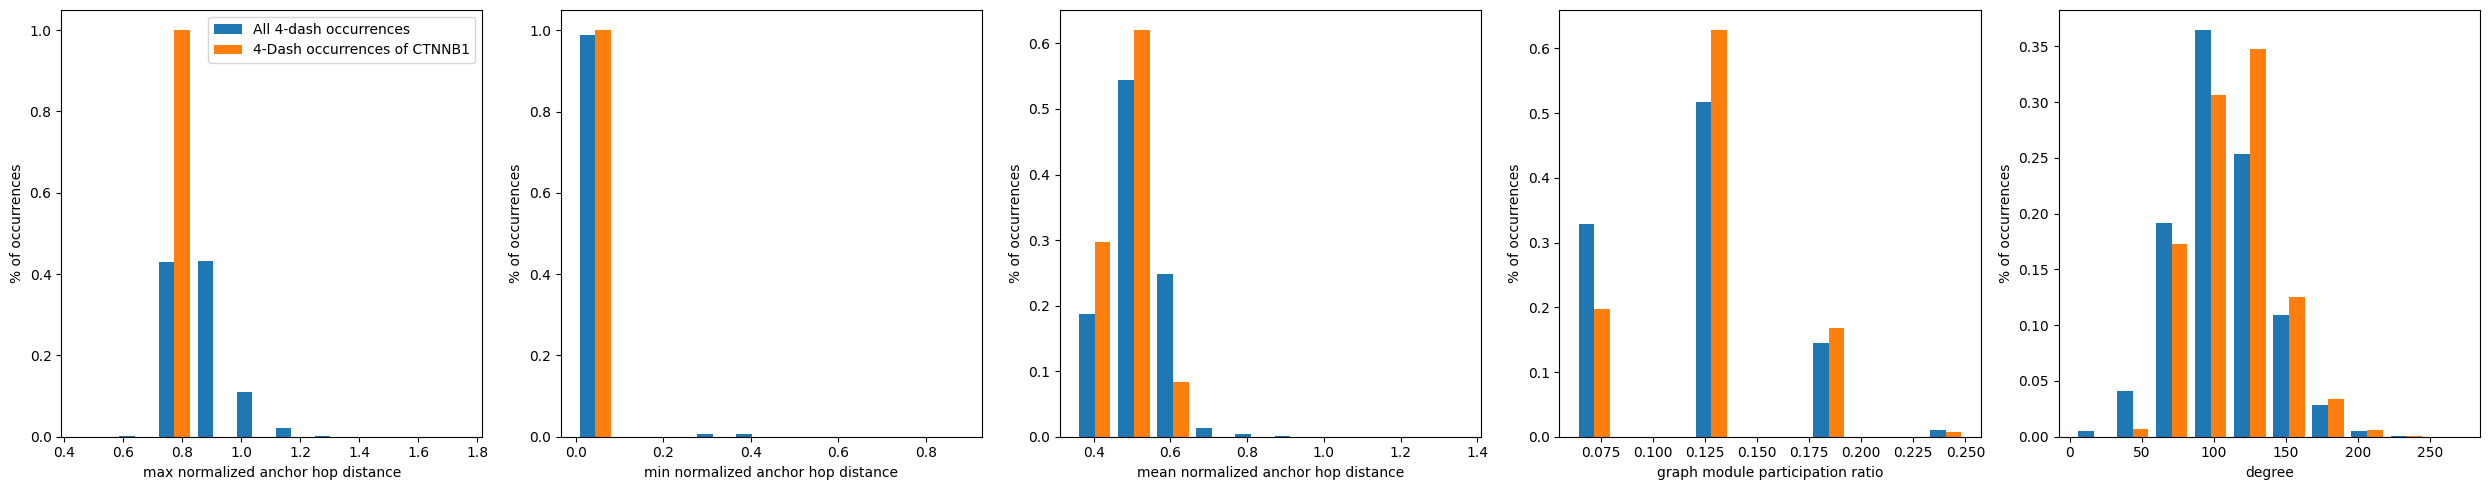

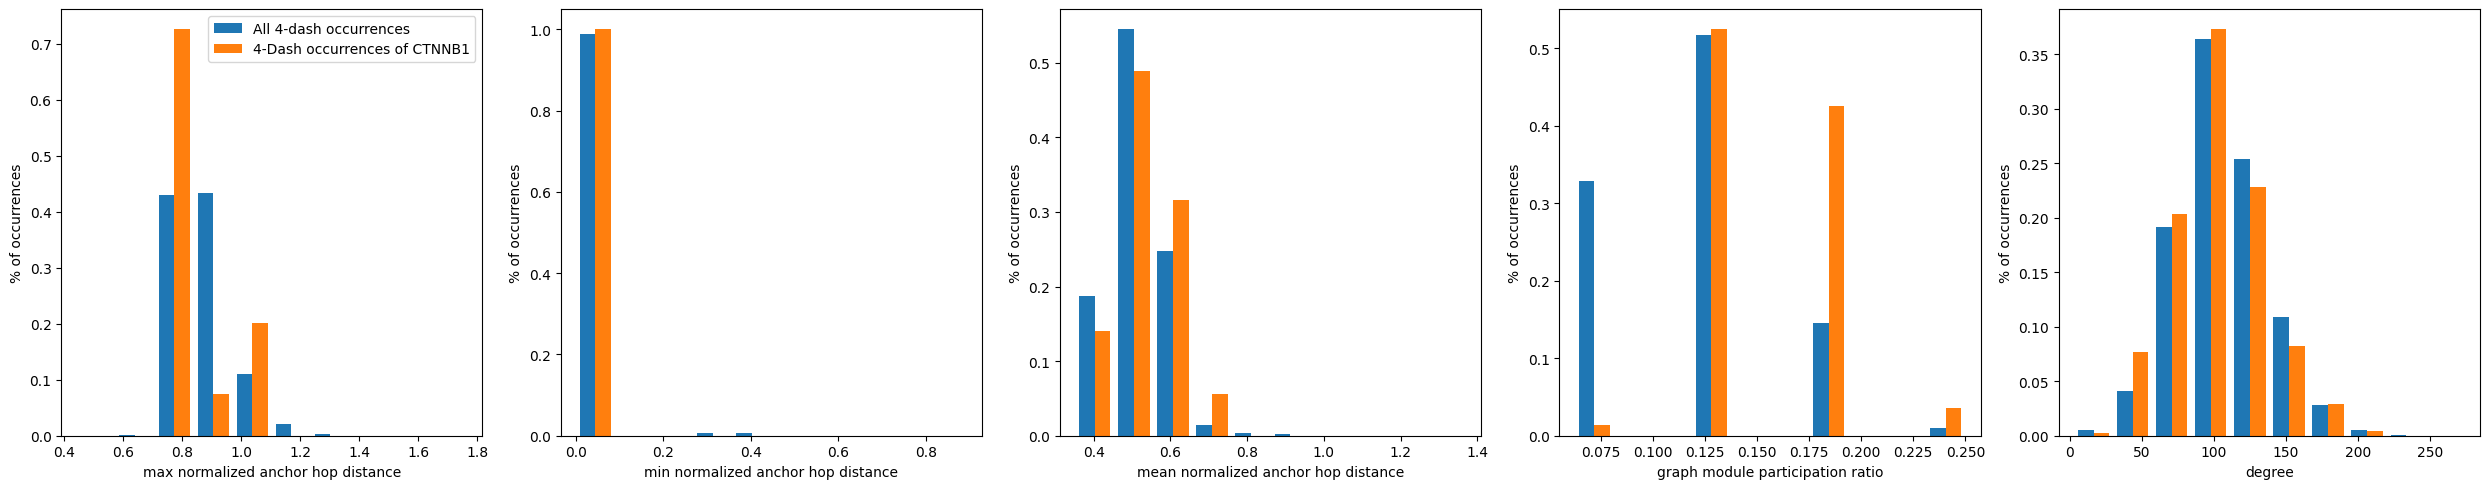

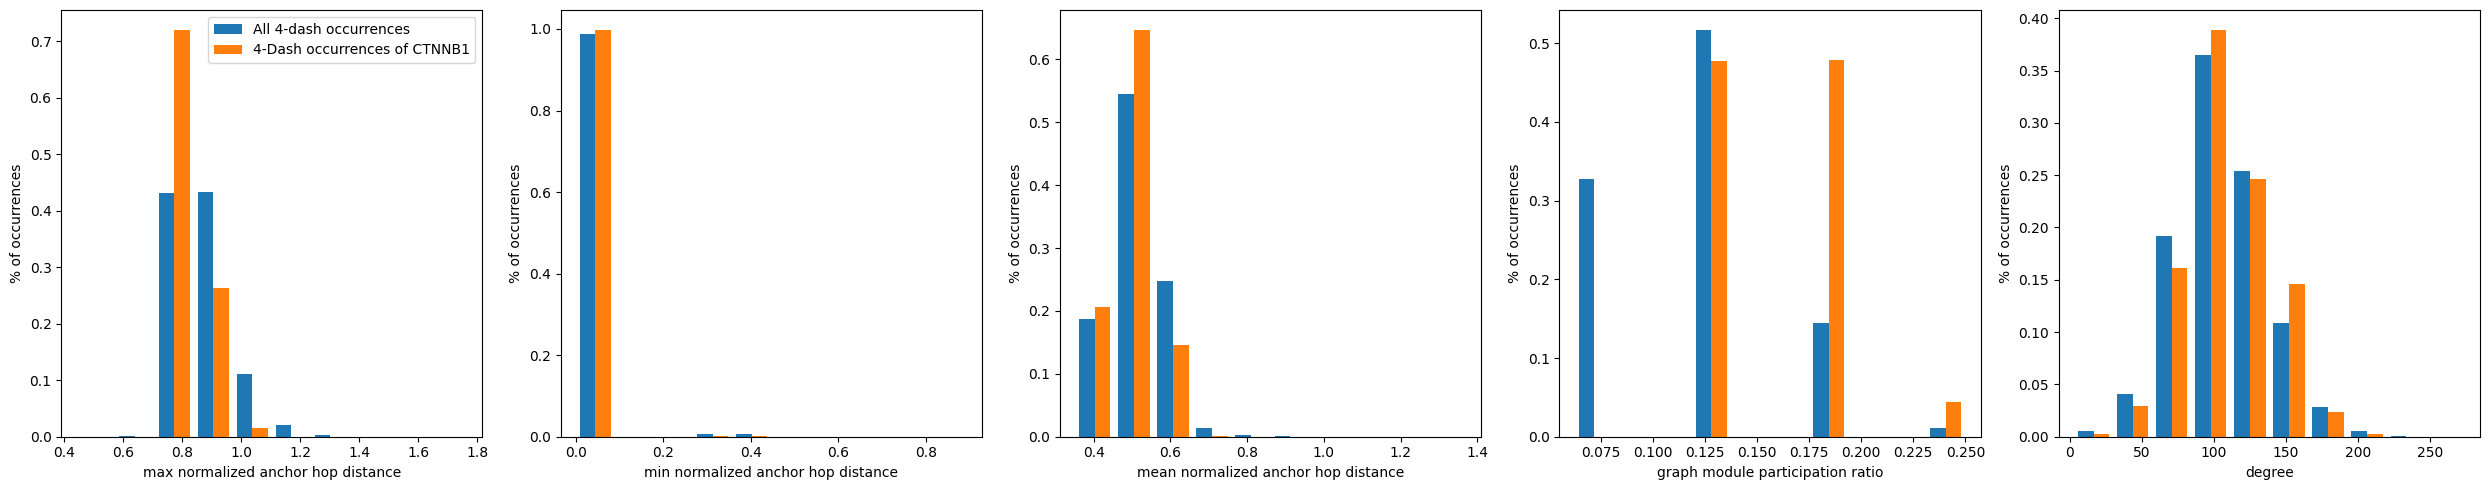

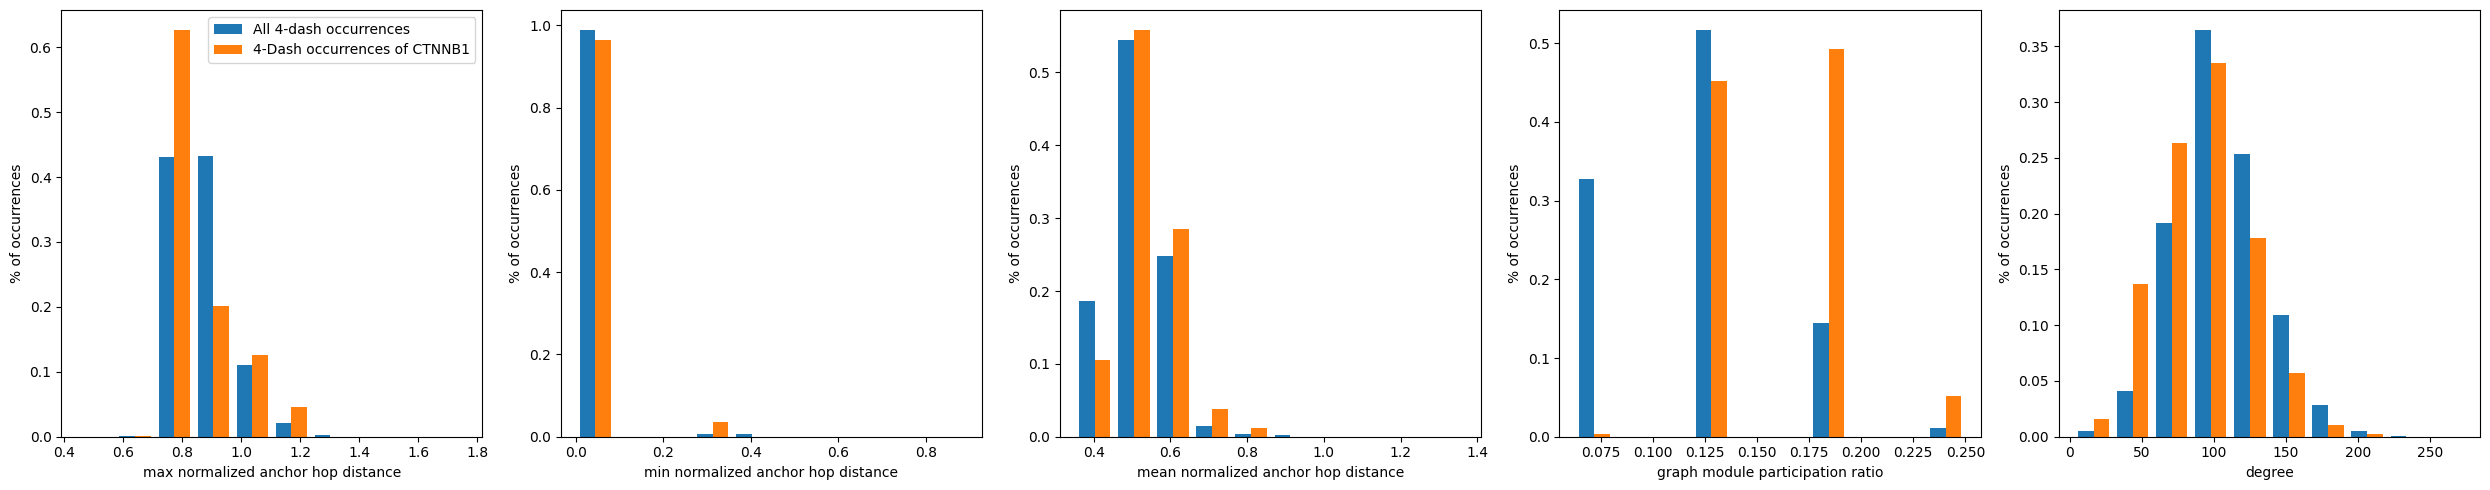

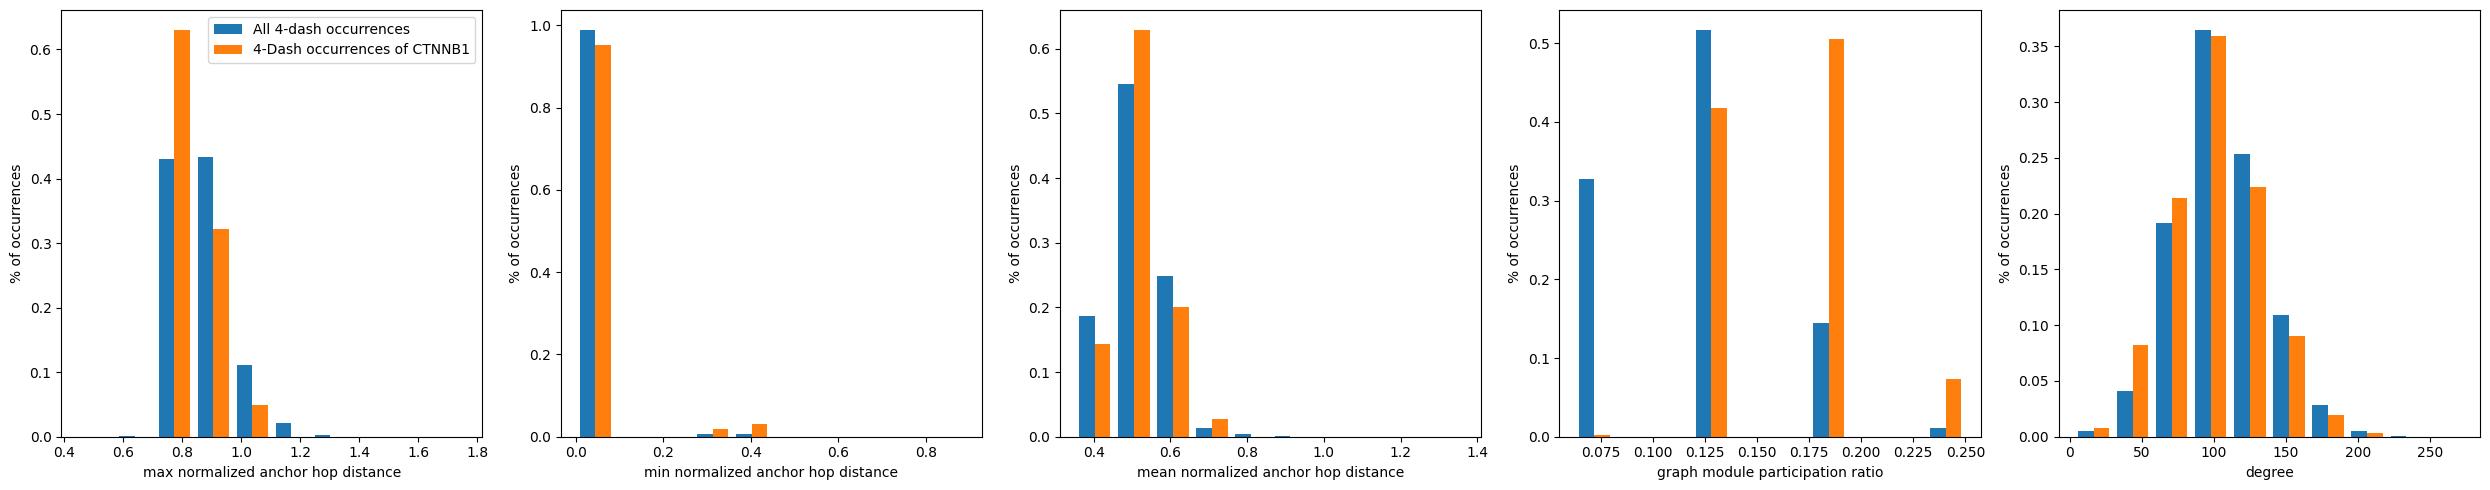

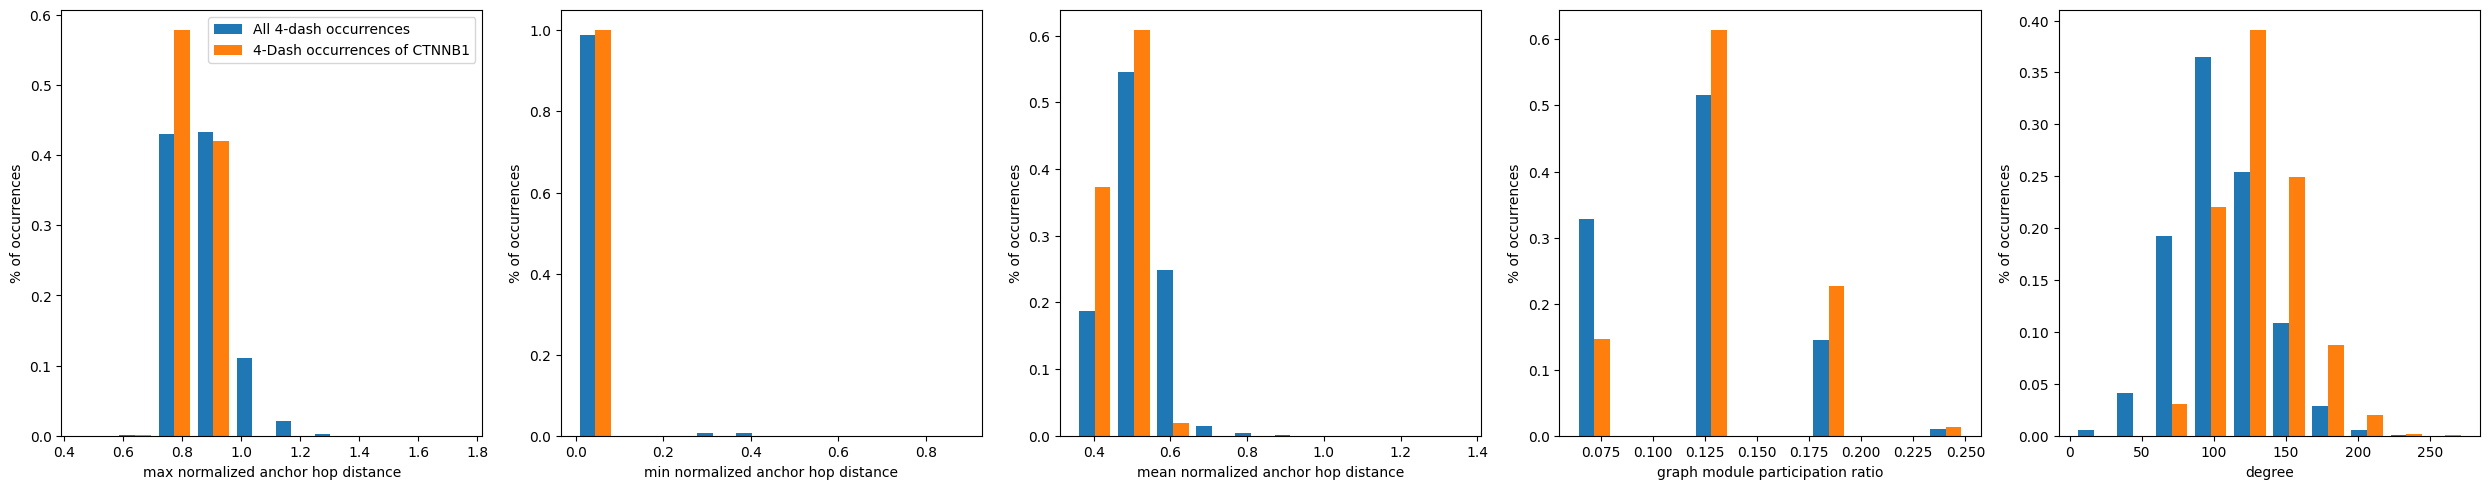

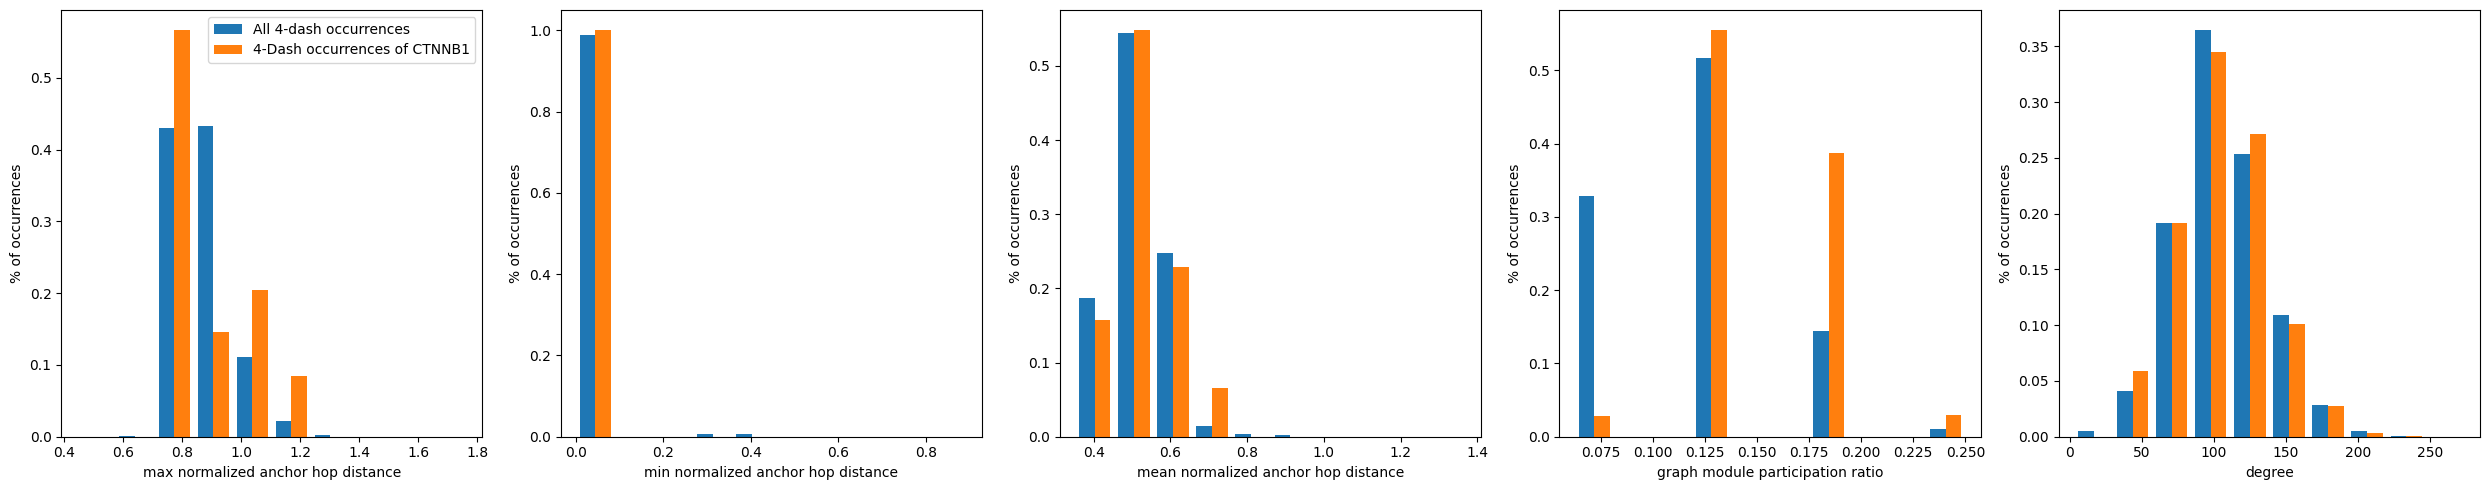

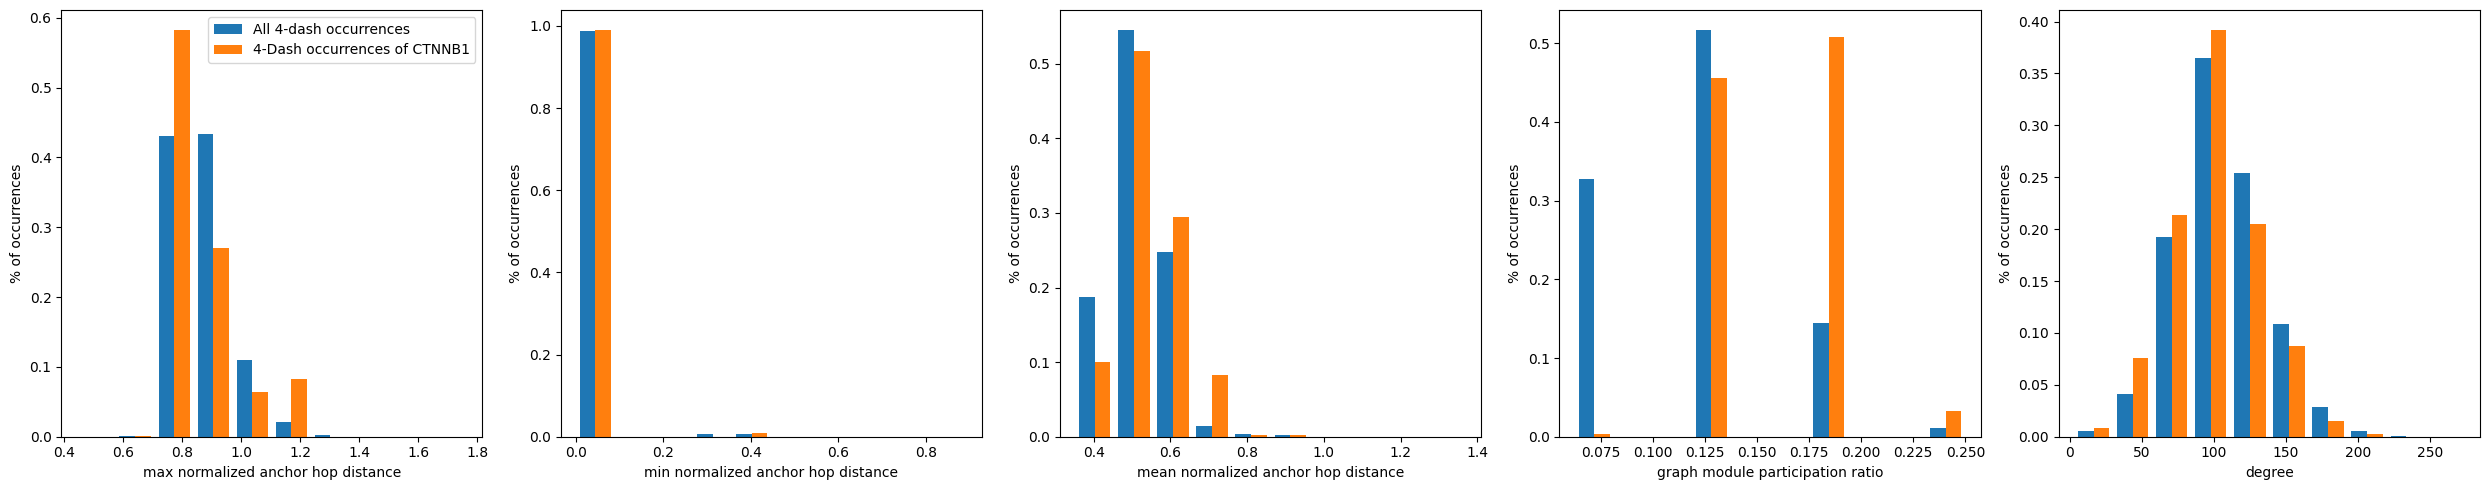

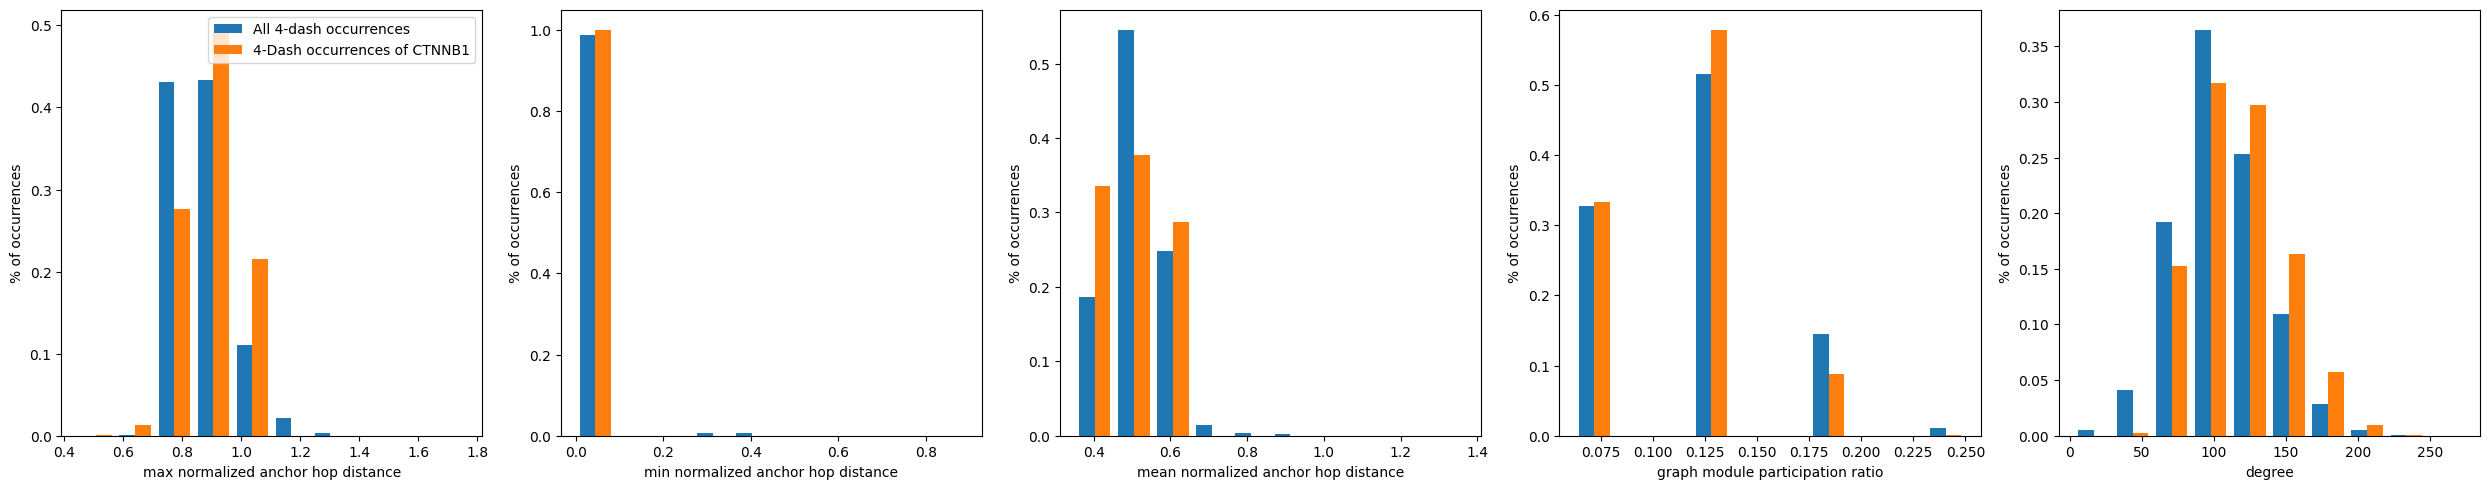

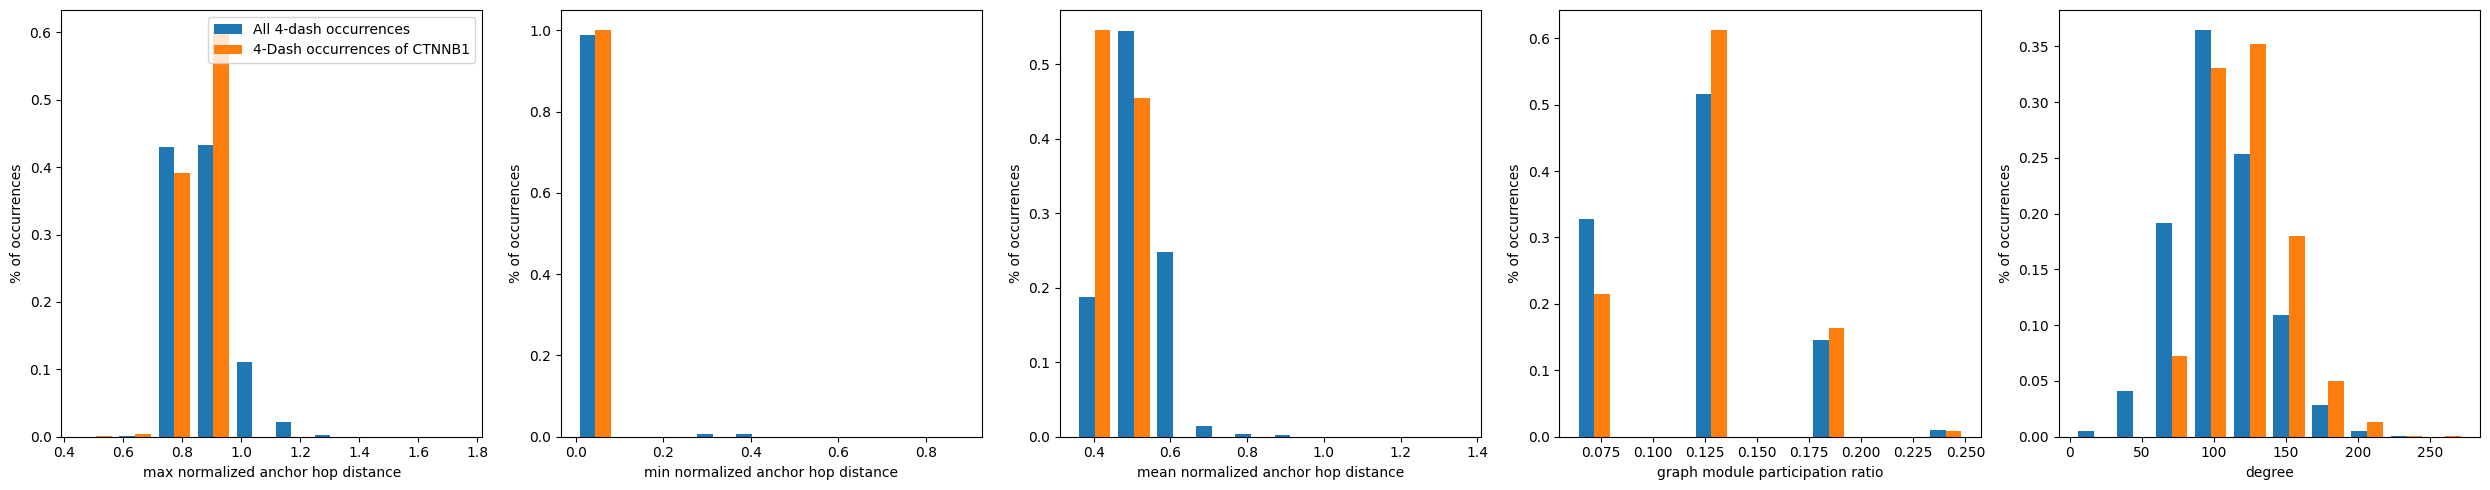

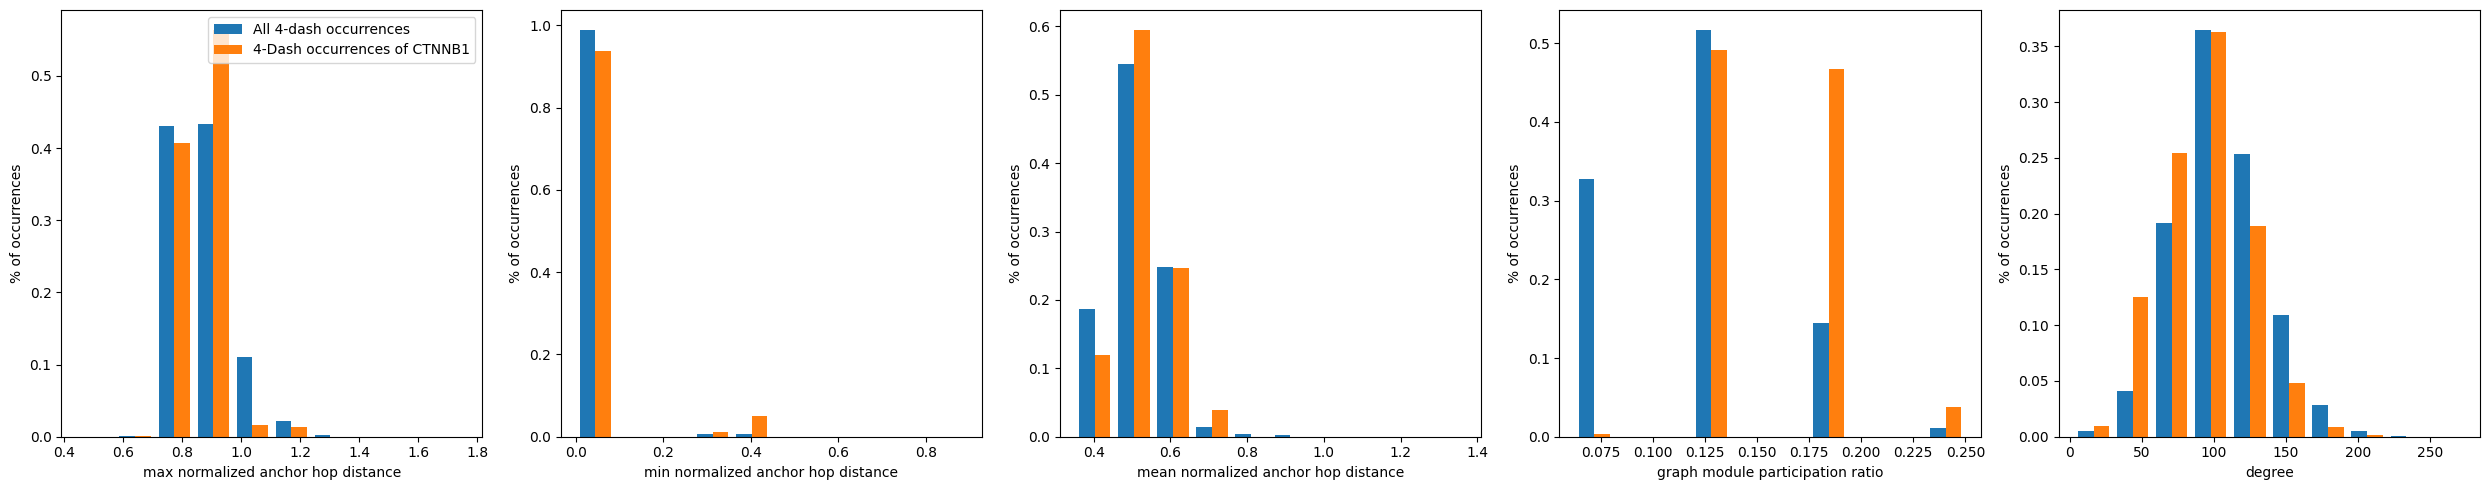

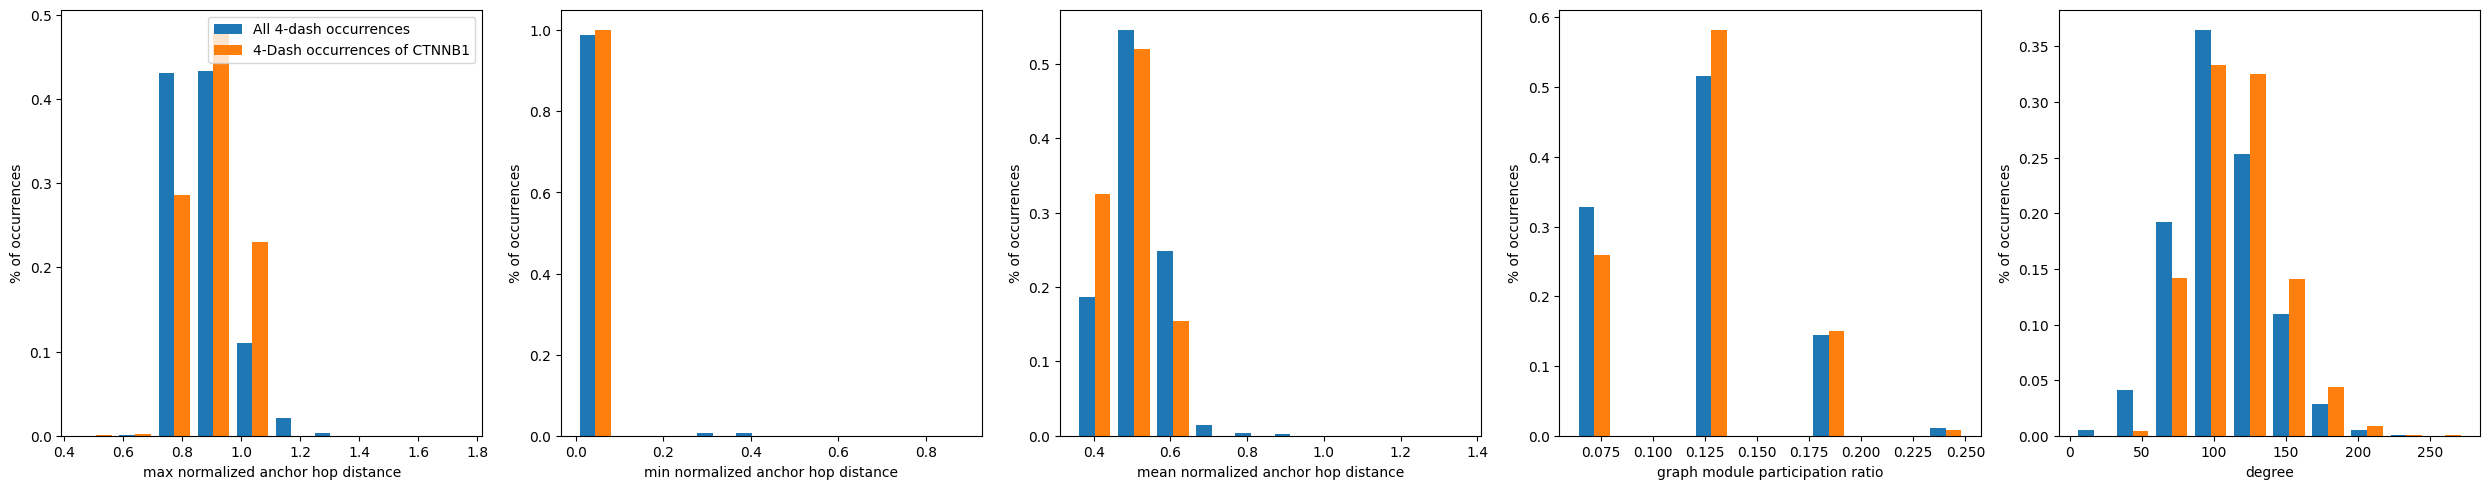

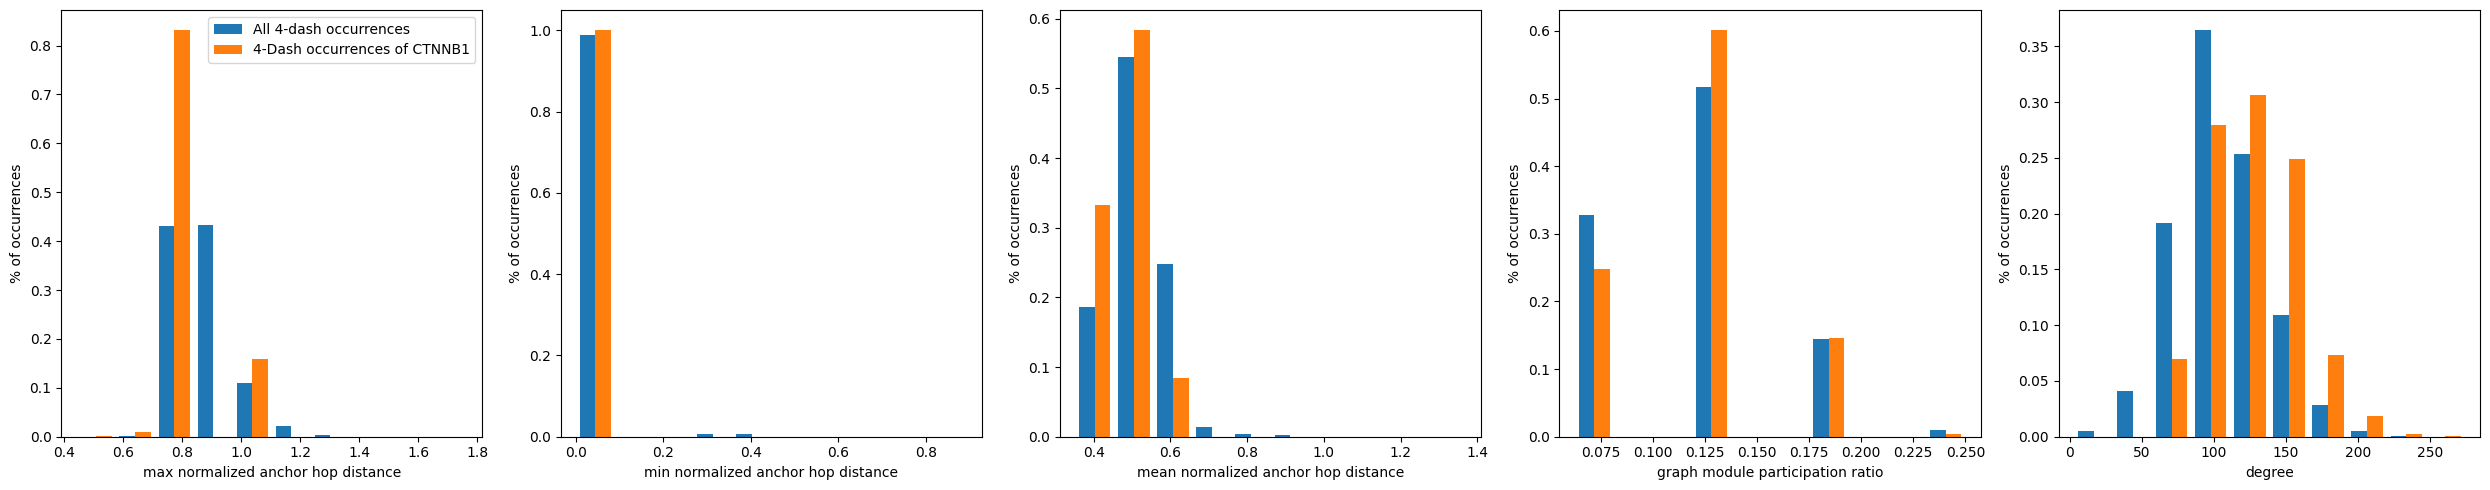

In [23]:
for n in {n for nodes in tops.values() for n in nodes}:
    plot_local_neighbourhood(4, "4-Dash", n)


In [24]:
import statistics as stat

degrees = dict(used_g.degree).values()
hub_degree = stat.mean(degrees) + stat.stdev(degrees)

In [25]:
closeness_centraltiy = nx.algorithms.centrality.closeness_centrality(used_g)

74
0.44


5it [00:00, 16.73it/s]


71
0.41


5it [00:00, 17.57it/s]


70
0.44


5it [00:00, 17.85it/s]


65
0.45


5it [00:00, 17.84it/s]


64
0.42


5it [00:00, 18.30it/s]


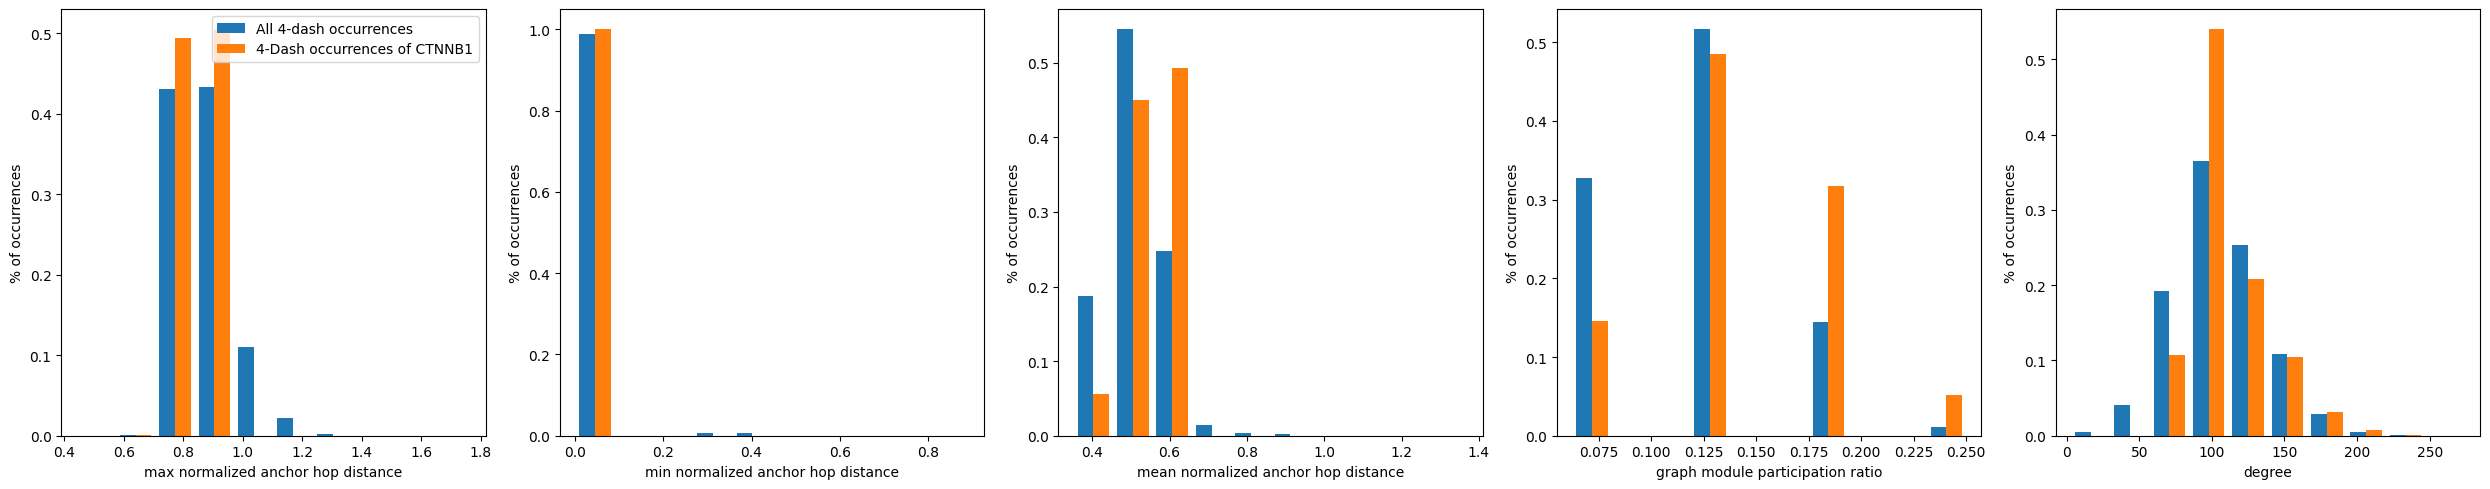

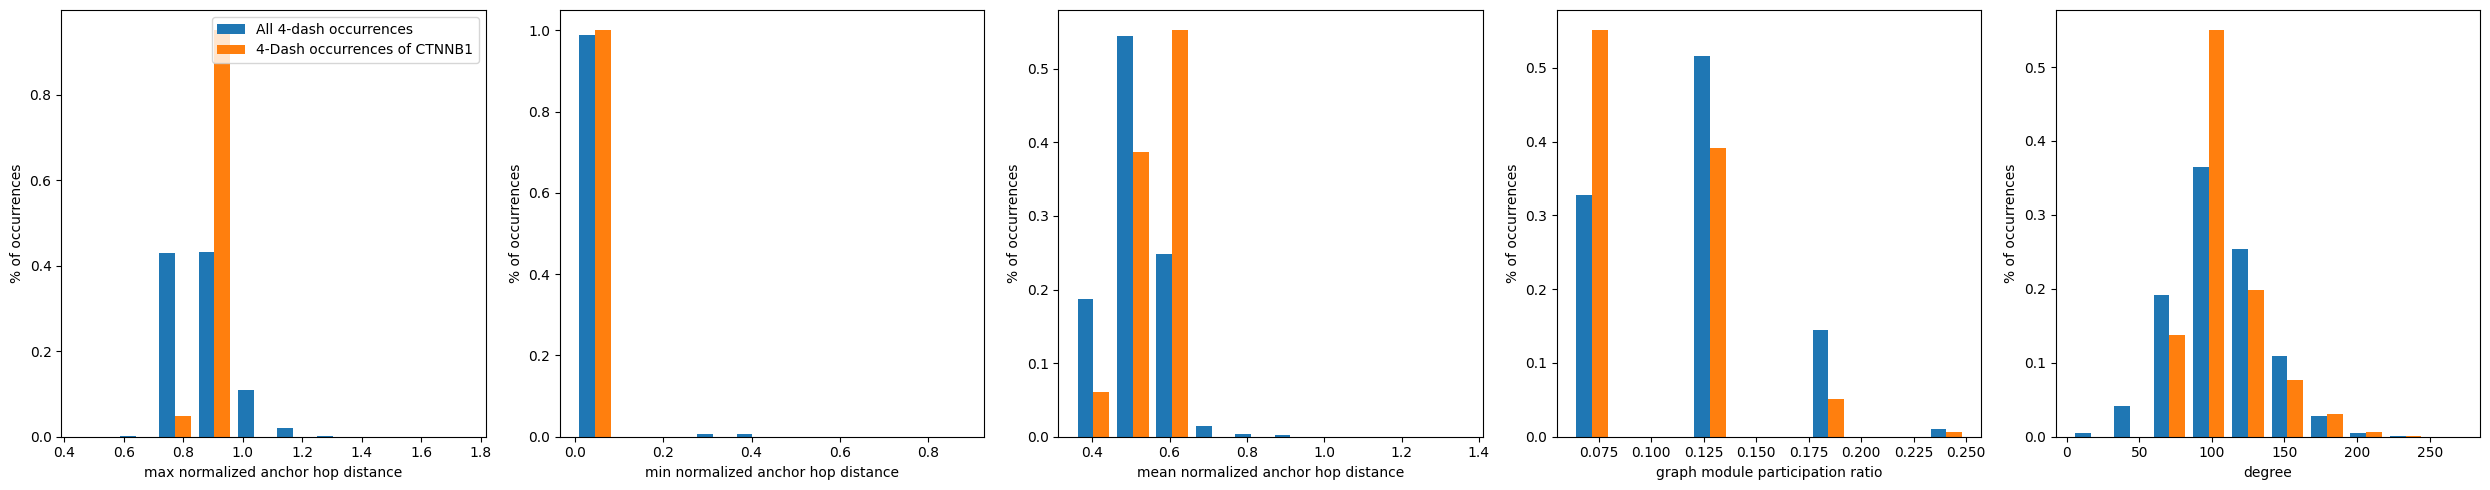

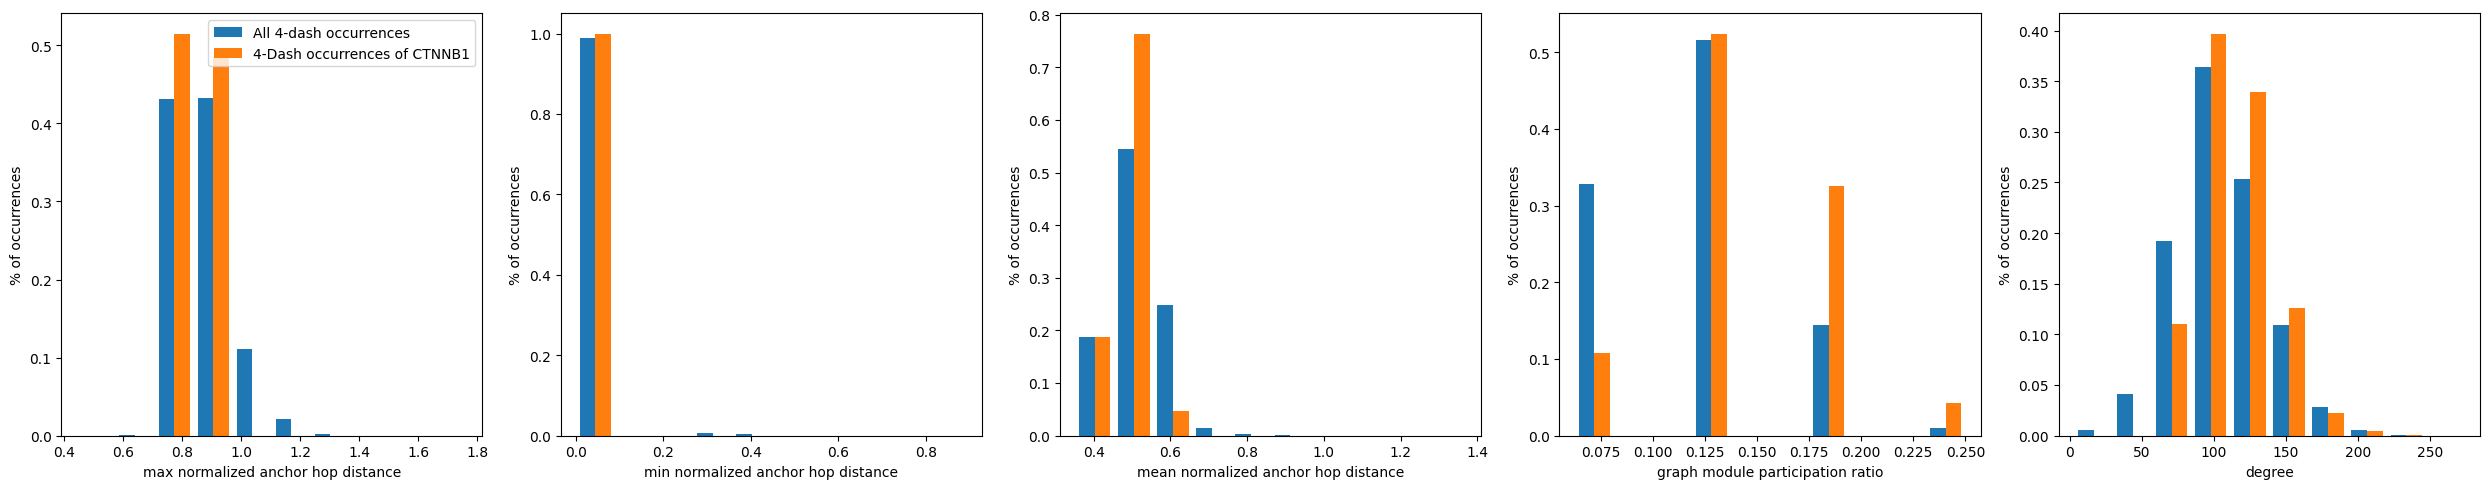

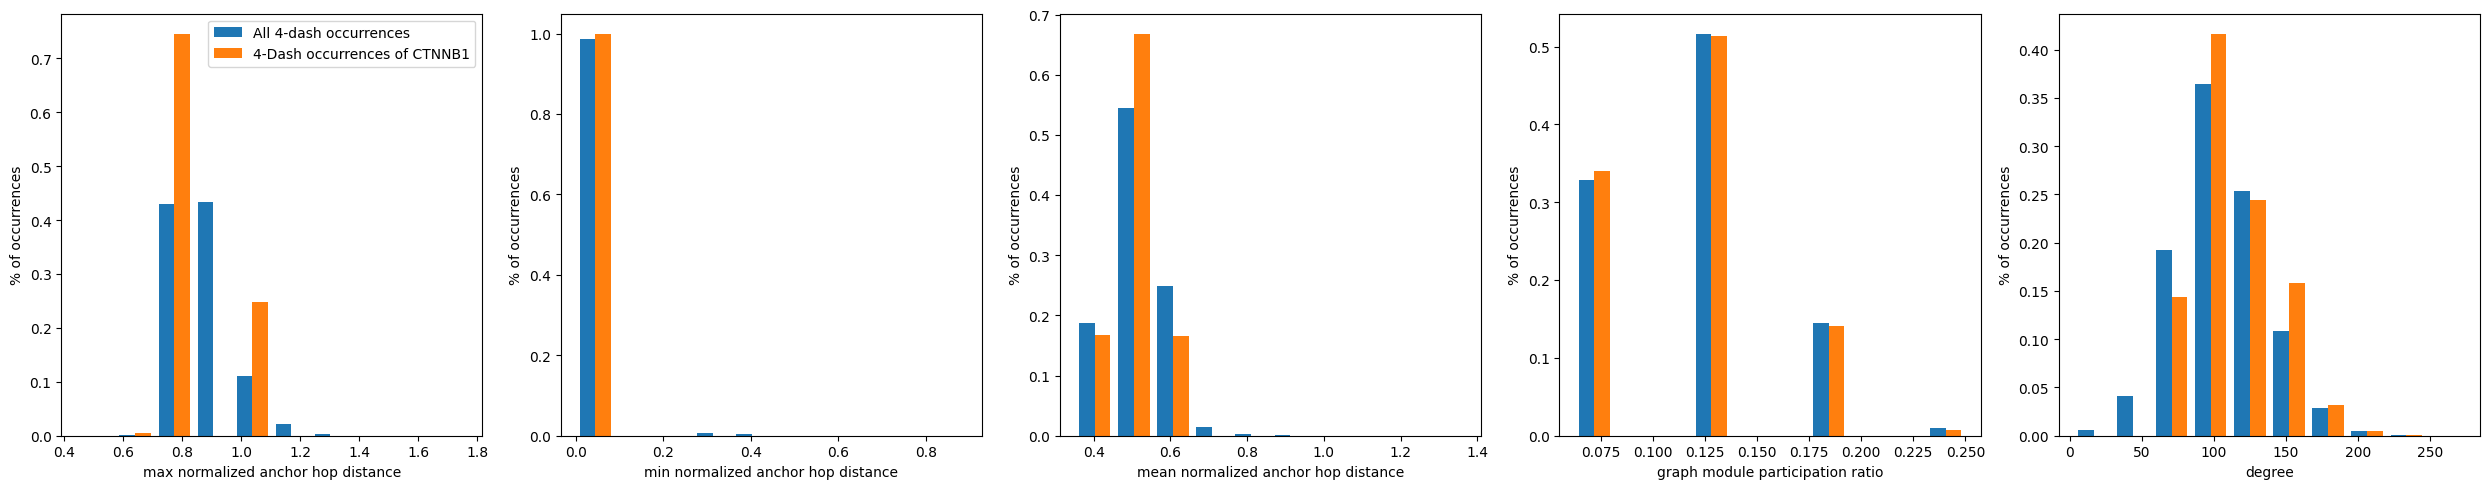

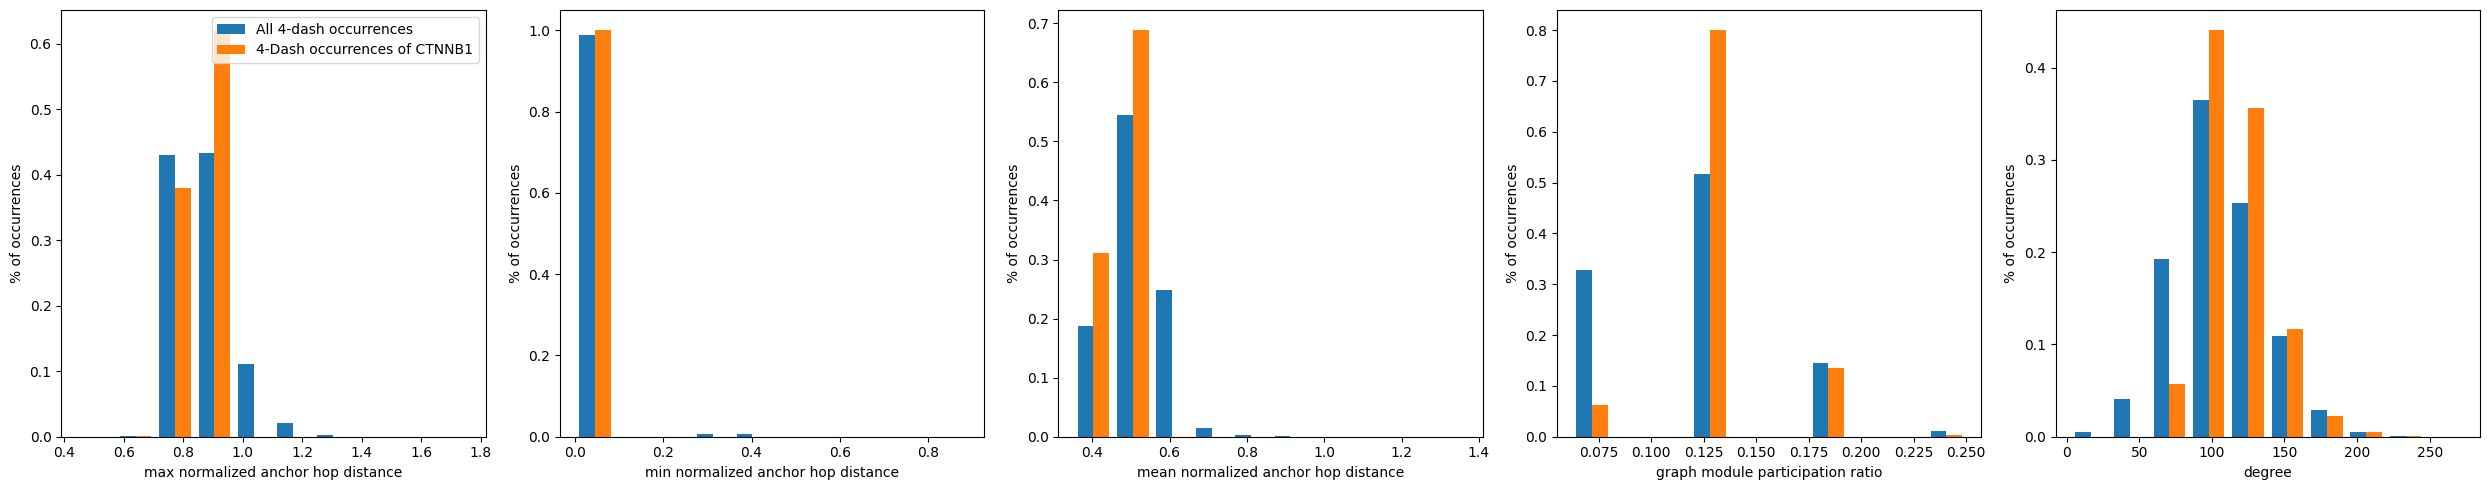

In [26]:
hub_nodes = {n:d for n, d in used_g.degree if d > hub_degree}
reverse_node_mapping = {v:k for k, v in node_mapping.items()}


for n,d  in sorted(hub_nodes.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(dict(used_g.degree)[n])
    print(round(closeness_centraltiy[n],2))
    plot_local_neighbourhood(4, "Fork", reverse_node_mapping[n])


3it [00:00,  6.30it/s]


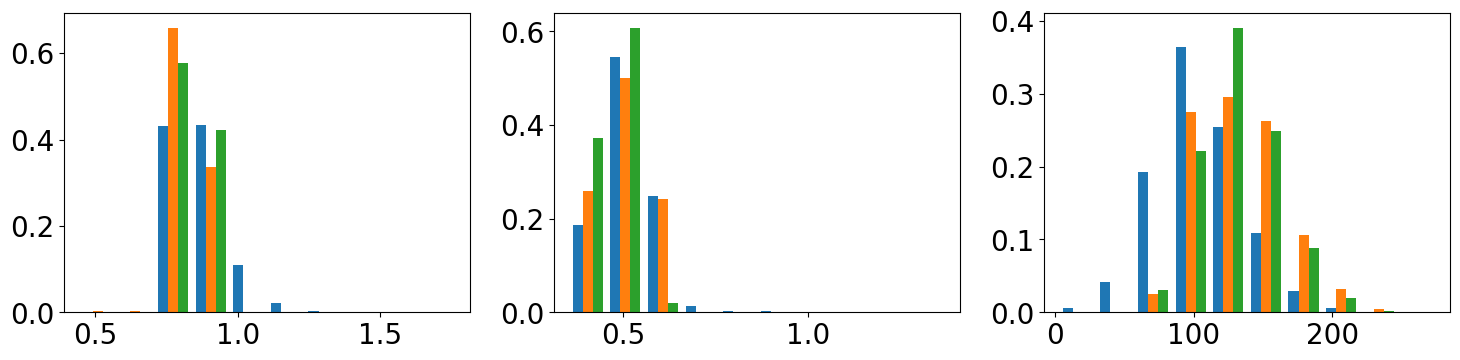

In [103]:
"""Plot multiple nodes in a local neighborhood"""
import numpy as np

k = 4
graphlet_class_name = "4-Dash"

def plot_local_neighbourhood_multiple_nodes(k, gc, nodes):
    graphlet_class = graphlet_name_to_class(gc)
    nodes = [node_mapping[node_name] for node_name in nodes]
    

    metric_names = [
        'max normalized anchor hop distance',
        # 'min normalized anchor hop distance',
        'mean normalized anchor hop distance',
        # 'graph module participation ratio',
        'degree',
    ]
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 4))

    # fig.suptitle(dict(k=k, graphlet_class=graphlet_class))
    
    node_metrics = {
        n: get_relevant_occurrences(k, n, graphlet_class=graphlet_class)
        for n in nodes
    }

    df = get_result_df(k)
    
    
    for i, m in tqdm(enumerate(metric_names)):
        ax = axes[i]
        # ax.set_xlabel(m)
        # ax.set_ylabel("% of graphlet occurrences")
        
        node_metric_values = [
            list(node_metrics[n][m]) * 10
            for n in nodes
        ]
        data = [df[m]] + node_metric_values
        x, bins, patches = ax.hist(
            data,
            label=["All occurrences"] + [reverse_node_mapping[n] for n in node_metrics.keys()],
            weights=[np.zeros_like(d) + 1. / len(d) for d in data],
        )
    # axes[0].legend(loc=(3,3))
    fig.tight_layout()
    return fig


matplotlib.rcParams.update({'font.size': 20})
fig = plot_local_neighbourhood_multiple_nodes(k, graphlet_class_name, ["TP53", "CTNNB1"])
pass
fig.savefig("human_cancer_local_neigh.pdf")

Note: Data except for All is rendered with factor of 1


0it [00:00, ?it/s]

min [0.44495412844036697, 0.44495412844036697, 0.44495412844036697]
max [1.7446043165467626, 0.8826205641492266, 0.8723021582733813]


1it [00:02,  2.87s/it]

min [0.35273714360595304, 0.35273714360595304, 0.35273714360595304]
max [1.2834969351239163, 0.60089794514429, 0.5560009643796866]


2it [00:05,  2.84s/it]

min [3, 74, 69]
max [274, 274, 274]


3it [00:08,  2.77s/it]


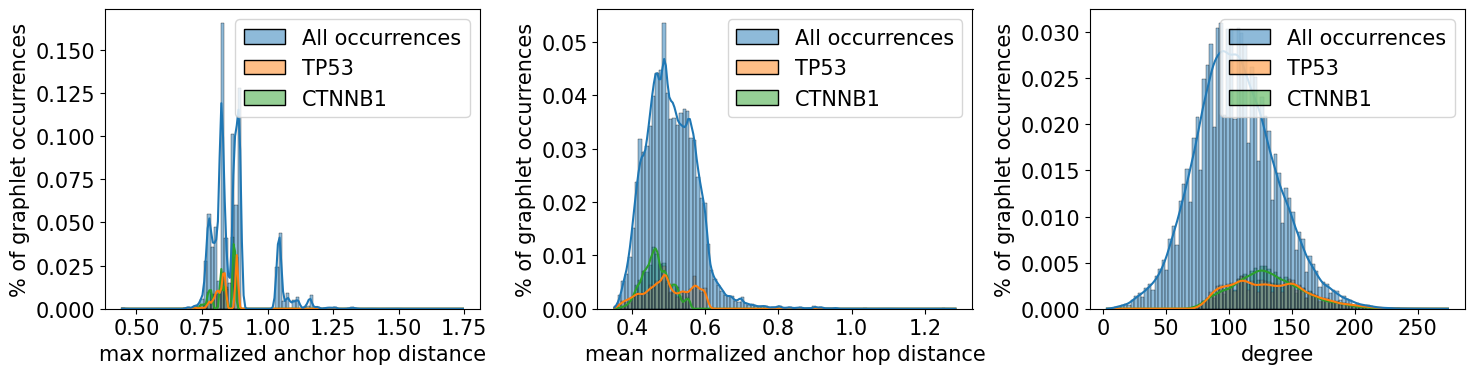

In [159]:
"""Plot multiple nodes in a local neighborhood"""
import numpy as np
import seaborn as sns

k = 4
graphlet_class_name = "4-Dash"
factor = 1


def plot_local_neighbourhood_multiple_nodes_seaborn(k, gc, nodes):
    graphlet_class = graphlet_name_to_class(gc)
    nodes = [node_mapping[node_name] for node_name in nodes]
    

    metric_names = [
        'max normalized anchor hop distance',
        # 'min normalized anchor hop distance',
        'mean normalized anchor hop distance',
        # 'graph module participation ratio',
        'degree',
    ]
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 4))

    # fig.suptitle(dict(k=k, graphlet_class=graphlet_class))
    
    node_metrics = {
        n: get_relevant_occurrences(k, n, graphlet_class=graphlet_class)
        for n in nodes
    }

    df = get_result_df(k)
    df = df[df["graphlet_class"] == graphlet_class]
    
    
    for i, m in tqdm(enumerate(metric_names)):
        ax = axes[i]
        ax.set_xlabel(m)
        ax.set_ylabel("% of graphlet occurrences")
        
        node_metric_values = [
            list(node_metrics[n][m]) * factor
            for n in nodes
        ]
        data = [list(df[m])] + node_metric_values
        labels = ["All occurrences"] + [reverse_node_mapping[n] for n in node_metrics.keys()]
        
        print("min", [min(d) for d in data])
        print("max", [max(d) for d in data])

        
        weights = [[np.zeros_like(d) + 1. / len(d)] for d in data]
        sns.histplot(
            data=dict(zip(labels, data)),
            stat='proportion',
            kde=True,
            ax=ax,
            bins=100,
            # palette=["tab:cyan", "tab:orange", "tab:blue"]
        )

    fig.tight_layout()
    return fig

print(f"Note: Data except for All is rendered with factor of {factor}")

matplotlib.rcParams.update({'font.size': 15})
fig = plot_local_neighbourhood_multiple_nodes_seaborn(k, graphlet_class_name, ["TP53", "CTNNB1"])
pass
fig.savefig("human_cancer_local_neigh.pdf")

In [33]:
node_mapping["CTNNB1"] in hub_nodes

True

0it [00:00, ?it/s]/home/timgarrels/Projects/pmotif_publication/.venv/lib/python3.10/site-packages/matplotlib-3.7.1-py3.10-linux-x86_64.egg/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/timgarrels/Projects/pmotif_publication/.venv/lib/python3.10/site-packages/matplotlib-3.7.1-py3.10-linux-x86_64.egg/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
3it [00:00, 21.60it/s]

306       0.834050
707       0.834050
777       0.834050
913       0.720654
1876      0.834050
            ...   
638677    0.882621
638678    0.882621
638679    0.882621
638683    0.882621
638684    0.882621
Name: max normalized anchor hop distance, Length: 39685, dtype: float64
306       0.0
707       0.0
777       0.0
913       0.0
1876      0.0
         ... 
638677    0.0
638678    0.0
638679    0.0
638683    0.0
638684    0.0
Name: min normalized anchor hop distance, Length: 39685, dtype: float64
306       0.420743
707       0.420743
777       0.404324
913       0.377821
1876      0.420743
            ...   
638677    0.593479
638678    0.593479
638679    0.593479
638683    0.593479
638684    0.593479
Name: mean normalized anchor hop distance, Length: 39685, dtype: float64
306       0.1875
707       0.1875
777       0.1250
913       0.1250
1876      0.2500
           ...  
638677    0.1250
638678    0.1250
638679    0.1250
638683    0.1250
638684    0.1875
Name: graph module parti

5it [00:00, 22.51it/s]


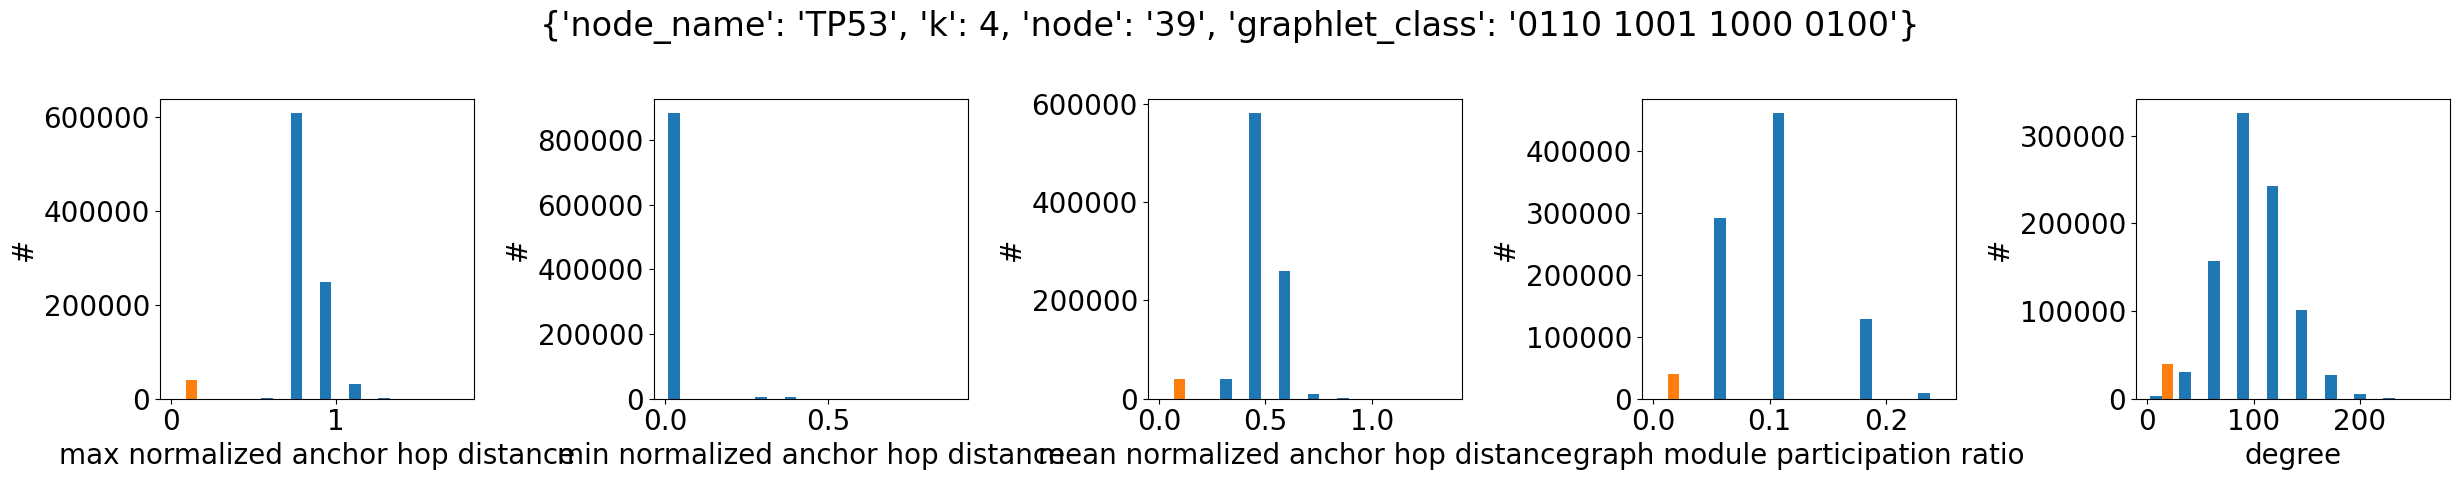

In [34]:
"""Pots a histogram of pmetric values and highlights the values of graphlet occurrences
hich are in the nieghbour hood of the given node

This time with relative scaling
"""
k = 4
graphlet_class_name = "4-Dash"
node = "TP53"

def plot_local_neighbourhood(k, gc, node_name):
    graphlet_class = graphlet_name_to_class(graphlet_class_name)
    node = node_mapping[node_name]
    

    metric_names = [name for consolidation in metrics.values() for name, _ in consolidation]
    fig, axes = plt.subplots(1, len(metric_names), figsize=(5*len(metric_names), 5))

    fig.suptitle(dict(node_name=node_name, k=k, node=node, graphlet_class=graphlet_class))

    df = get_result_df(k)
    relevant = get_relevant_occurrences(k, node, graphlet_class=graphlet_class)
    for i, m in tqdm(enumerate(metric_names)):
        ax = axes[i]
        ax.set_xlabel(m)
        ax.set_ylabel("#")

        print(relevant[m])
        local_n_metric_values = relevant[m] / sum(relevant[m])
        x, bins, patches = ax.hist([
            df[m],
            list(local_n_metric_values),
        ])
    fig.tight_layout()
    return fig

plot_local_neighbourhood(k, graphlet_class_name, node)
pass

In [35]:
modules = nx.algorithms.community.greedy_modularity_communities(used_g)

In [36]:
module_lookup = {i: list(nodeset) for i, nodeset in enumerate(modules)}
reverse_module_lookup = {node: i for i, nodeset in module_lookup.items() for node in nodeset}

In [37]:
from collections import defaultdict

module_spanning_edge_counter = defaultdict(lambda: 0)

for u, v in used_g.edges():
    if reverse_module_lookup[u] != reverse_module_lookup[v]:
        module_spanning_edge_counter[u] += 1
        module_spanning_edge_counter[v] += 1

In [38]:
# Map back to real names
module_spanning_edge_counter_real = {
    reverse_node_mapping[n]: c
    for n,c in module_spanning_edge_counter.items()
}
module_spanning_edge_counter_real = dict(sorted(
    module_spanning_edge_counter_real.items(), key=lambda x: x[1], reverse=True
))
module_spanning_edge_counter_real

{'STAT3': 40,
 'CTNNB1': 35,
 'TP53': 33,
 'AKT1': 24,
 'SRC': 16,
 'BRCA1': 16,
 'EP300': 15,
 'JUN': 15,
 'SMARCA4': 14,
 'ESR1': 12,
 'ABL1': 12,
 'PTEN': 12,
 'EGFR': 10,
 'PIK3CA': 10,
 'HRAS': 10,
 'CASP3': 10,
 'CREBBP': 10,
 'AR': 9,
 'AXIN1': 9,
 'VEGFA': 9,
 'RHOA': 9,
 'LYN': 9,
 'MTOR': 9,
 'MDM2': 9,
 'MUC1': 8,
 'MYC': 8,
 'IL1B': 8,
 'JAK2': 8,
 'EZH2': 8,
 'TNF': 8,
 'ATM': 8,
 'ERBB2': 7,
 'YWHAE': 7,
 'CDKN2A': 7,
 'IL6': 7,
 'STAT5B': 7,
 'FOS': 6,
 'BTK': 6,
 'ACTB': 6,
 'STK11': 6,
 'ARID1A': 6,
 'SUZ12': 6,
 'NF1': 6,
 'CDH1': 5,
 'CD19': 5,
 'IL2': 5,
 'POMC': 5,
 'EPAS1': 5,
 'CDK2': 5,
 'TSC2': 5,
 'IRF1': 5,
 'IL4': 5,
 'BCL6': 5,
 'FAS': 4,
 'EPS15': 4,
 'CASP8': 4,
 'SMAD4': 4,
 'CTNNA1': 4,
 'APC': 4,
 'EGF': 4,
 'PTPN11': 4,
 'LGALS3': 4,
 'RAC1': 4,
 'FYN': 4,
 'KRAS': 4,
 'PDGFRB': 4,
 'IL10': 4,
 'PDGFB': 4,
 'CD79A': 4,
 'CD79B': 4,
 'CDKN1B': 4,
 'CDKN1A': 4,
 'CCND1': 4,
 'TERT': 4,
 'CDK4': 4,
 'SMARCB1': 4,
 'RAF1': 4,
 'RB1': 4,
 'RAD51': 4,
 'MDM

In [39]:
# Map back to real names
module_spanning_edge_counter_relative = {
    n: c / dict(used_g.degree)[node_mapping[n]]
    for n,c in module_spanning_edge_counter_real.items()
}
module_spanning_edge_counter_relative = dict(sorted(
    module_spanning_edge_counter_relative.items(), key=lambda x: x[1], reverse=True
))
module_spanning_edge_counter_relative

{'PTEN': 0.75,
 'CSF1R': 0.75,
 'TOP1': 0.75,
 'MUC1': 0.7272727272727273,
 'CASP3': 0.7142857142857143,
 'TSC2': 0.7142857142857143,
 'IL1B': 0.6666666666666666,
 'STK11': 0.6666666666666666,
 'FAS': 0.6666666666666666,
 'MDM4': 0.6666666666666666,
 'GAPDH': 0.6666666666666666,
 'DAB2IP': 0.6666666666666666,
 'HLA-B': 0.6666666666666666,
 'SLC2A4': 0.6666666666666666,
 'AXIN1': 0.6428571428571429,
 'STAT3': 0.625,
 'POMC': 0.625,
 'EPAS1': 0.625,
 'MTOR': 0.6,
 'VHL': 0.6,
 'APC': 0.5714285714285714,
 'CD19': 0.5555555555555556,
 'SUZ12': 0.5454545454545454,
 'NF1': 0.5454545454545454,
 'SMARCA4': 0.5384615384615384,
 'TNF': 0.5333333333333333,
 'CTNNB1': 0.5,
 'YWHAE': 0.5,
 'EPS15': 0.5,
 'CTNNA1': 0.5,
 'CD79B': 0.5,
 'B2M': 0.5,
 'MUC4': 0.5,
 'DROSHA': 0.5,
 'KEAP1': 0.5,
 'IGF2': 0.5,
 'PRKCI': 0.5,
 'PRKAA1': 0.5,
 'CD22': 0.5,
 'FCGR2B': 0.5,
 'VCP': 0.5,
 'CD82': 0.5,
 'KLK2': 0.5,
 'FRAT1': 0.5,
 'TLE1': 0.5,
 'ITGB5': 0.5,
 'MYH11': 0.5,
 'TNFSF11': 0.5,
 'MME': 0.5,
 'SPTA

In [40]:
graphlet_participation_counter = dict(Counter(tops))

In [41]:
indices = []
for n in used_g.nodes:
    n = reverse_node_mapping[n]
    
    
    try:
        edge_index = list(module_spanning_edge_counter_real.keys()).index(n)
    except ValueError:
        edge_index = -1
    
    try:
        graphlet_index = list(graphlet_participation_counter.keys()).index(n)
    except ValueError:
        graphlet_index = -1
        
    if graphlet_index == -1 and edge_index == -1:
        continue
    indices.append((edge_index, graphlet_index))

In [42]:
df.columns

Index(['graphlet_class', 'nodes', 'pGraphModuleParticipation', 'pDegree',
       'pAnchorNodeDistance', 'max normalized anchor hop distance',
       'min normalized anchor hop distance',
       'mean normalized anchor hop distance',
       'graph module participation ratio', 'degree', 'relevant'],
      dtype='object')

In [43]:
module_spanning_edge_counter_real

{'STAT3': 40,
 'CTNNB1': 35,
 'TP53': 33,
 'AKT1': 24,
 'SRC': 16,
 'BRCA1': 16,
 'EP300': 15,
 'JUN': 15,
 'SMARCA4': 14,
 'ESR1': 12,
 'ABL1': 12,
 'PTEN': 12,
 'EGFR': 10,
 'PIK3CA': 10,
 'HRAS': 10,
 'CASP3': 10,
 'CREBBP': 10,
 'AR': 9,
 'AXIN1': 9,
 'VEGFA': 9,
 'RHOA': 9,
 'LYN': 9,
 'MTOR': 9,
 'MDM2': 9,
 'MUC1': 8,
 'MYC': 8,
 'IL1B': 8,
 'JAK2': 8,
 'EZH2': 8,
 'TNF': 8,
 'ATM': 8,
 'ERBB2': 7,
 'YWHAE': 7,
 'CDKN2A': 7,
 'IL6': 7,
 'STAT5B': 7,
 'FOS': 6,
 'BTK': 6,
 'ACTB': 6,
 'STK11': 6,
 'ARID1A': 6,
 'SUZ12': 6,
 'NF1': 6,
 'CDH1': 5,
 'CD19': 5,
 'IL2': 5,
 'POMC': 5,
 'EPAS1': 5,
 'CDK2': 5,
 'TSC2': 5,
 'IRF1': 5,
 'IL4': 5,
 'BCL6': 5,
 'FAS': 4,
 'EPS15': 4,
 'CASP8': 4,
 'SMAD4': 4,
 'CTNNA1': 4,
 'APC': 4,
 'EGF': 4,
 'PTPN11': 4,
 'LGALS3': 4,
 'RAC1': 4,
 'FYN': 4,
 'KRAS': 4,
 'PDGFRB': 4,
 'IL10': 4,
 'PDGFB': 4,
 'CD79A': 4,
 'CD79B': 4,
 'CDKN1B': 4,
 'CDKN1A': 4,
 'CCND1': 4,
 'TERT': 4,
 'CDK4': 4,
 'SMARCB1': 4,
 'RAF1': 4,
 'RB1': 4,
 'RAD51': 4,
 'MDM

In [44]:
df = pd.DataFrame()
df["Rank"] = list(range(top_x))
for k, v in tops.items():
    df[k] = [
        (node, list(module_spanning_edge_counter_real.keys()).index(node))
        for node in v
    ]
df["Inter-Module Edges"] = list(module_spanning_edge_counter_real.keys())[:top_x]

df

,Rank,4-Dash,Fork,Spoon,Square,Crossed Square,Double Crossed Square,Inter-Module Edges
0,0,"(TP53, 2)","(TP53, 2)","(TP53, 2)","(STAT3, 0)","(STAT3, 0)","(STAT3, 0)",STAT3
1,1,"(CTNNB1, 1)","(CTNNB1, 1)","(CTNNB1, 1)","(AKT1, 3)","(SRC, 4)","(SRC, 4)",CTNNB1
2,2,"(PTEN, 11)","(MUC1, 24)","(BRCA1, 5)","(CTNNB1, 1)","(CTNNB1, 1)","(CTNNB1, 1)",TP53
3,3,"(BRCA1, 5)","(PTEN, 11)","(PTEN, 11)","(HRAS, 14)","(AKT1, 3)","(PIK3CA, 13)",AKT1
4,4,"(SMARCA4, 8)","(SMARCA4, 8)","(MUC1, 24)","(SRC, 4)","(PIK3CA, 13)","(PTPN11, 60)",SRC
5,5,"(AKT1, 3)","(AURKA, 98)","(SMARCA4, 8)","(KRAS, 64)","(EGFR, 12)","(EGFR, 12)",BRCA1
6,6,"(SRC, 4)","(VHL, 88)","(AKT1, 3)","(JUN, 7)","(TP53, 2)","(AKT1, 3)",EP300
7,7,"(MUC1, 24)","(BRCA1, 5)","(STK11, 39)","(TP53, 2)","(PTPN11, 60)","(TP53, 2)",JUN
8,8,"(CASP3, 15)","(AKT1, 3)","(AURKA, 98)","(EP300, 6)","(EP300, 6)","(EGF, 59)",SMARCA4
9,9,"(NF1, 42)","(STK11, 39)","(CASP3, 15)","(PIK3CA, 13)","(JUN, 7)","(JUN, 7)",ESR1


In [45]:
"""Ranking for all nodes"""
from pmotif_lib.graphlet_representation import graphlet_classes_from_size
k = 4
node_rank_lookup = {}

for g_c in graphlet_classes_from_size(k):
    g_c_name = graphlet_class_to_name(g_c)
    df = get_node_ranking(k, g_c_name, "graph module participation ratio")
    df = df[["node", "frequency", "node name"]]
    # Add nodes outside of ranking
    missing_nodes = set(used_g.nodes) - set(df["node"])
    rows = [
        {"node": n, "frequency": 0, "node name": reverse_node_mapping[n]}
        for n in missing_nodes
    ]
    df = pd.concat([
        df,
        pd.DataFrame(rows),
    ])
    
    unique_frequencies = sorted(set(df["frequency"]), reverse=True)
    df["rank"] = df["frequency"].apply(lambda f: unique_frequencies.index(f))
    rank_lookup = {n_name: rank + 1 for i, (n_name, rank) in df[["node name", "rank"]].iterrows()}

    node_rank_lookup[g_c_name] = rank_lookup

missing_nodes = {reverse_node_mapping[n] for n in used_g.nodes} - set(module_spanning_edge_counter_real.keys())
missing_node_edges = {n: 0 for n in missing_nodes}
inter_module_edge_lookup = {}
inter_module_edge_lookup.update(module_spanning_edge_counter_real)
inter_module_edge_lookup.update(missing_node_edges)
unique_edge_counts = sorted(set(inter_module_edge_lookup.values()), reverse=True)

node_rank_lookup["Inter-Modules Edges"] = {
    n: unique_edge_counts.index(e) + 1
    for n, e in inter_module_edge_lookup.items()
}

In [46]:
df = pd.DataFrame(node_rank_lookup)
df.index.name = "Node"
df.to_excel("human_cancer_node_ranking.xlsx")
df.head()

,4-Dash,Fork,Spoon,Square,Crossed Square,Double Crossed Square,Inter-Modules Edges
Node,,,,,,,
TP53,1,1,1,8,7,8,3
CTNNB1,2,2,2,3,3,3,2
PTEN,3,4,4,41,39,35,8
BRCA1,4,8,3,16,13,13,5
SMARCA4,5,5,6,38,20,17,7


In [47]:
for c in df.columns:
    assert set(df[c].values) == set(range(1, max(df[c].values) + 1))